In [1]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 5)
import seaborn as sns
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from keras.layers import Concatenate

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import LineSentence
from gensim.models import FastText, KeyedVectors, Word2Vec

import lightgbm as lgb
import fastText
import xgboost as xgb
from xgboost import XGBClassifier

import tqdm
from tqdm import tqdm
import joblib
import pickle

from eli5 import show_weights
from scipy.sparse import coo_matrix, csr_matrix, hstack

from keras.models import Sequential, Model, load_model
from keras.layers import (
    GRU, Bidirectional, Embedding, TimeDistributed, Dense, Input, Activation, Dropout, BatchNormalization
)
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import initializers
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras_tqdm import TQDMNotebookCallback
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils.np_utils import to_categorical
from keras.layers.recurrent import LSTM

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from keras import backend as K
from keras.callbacks import TensorBoard
from importlib import reload
import bat_logger
from bat_logger import TFLogger
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

C:\Users\vaski\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\vaski\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Считывание данных

#### Обучение

In [2]:
train_data = []
with open('data/umc-0.1-corpus/English-Russian.1-1.txt', 'r', encoding="utf8") as f:
    for line in f:
        train_data.append(line.strip().split('\t'))
train_data = pd.DataFrame(train_data, columns=['english', 'russian'])

In [ ]:
train_data.shape

In [4]:
train_data.head()

,english,russian
0,Musharraf ’ s Last Act ?,Последний ход Мушаррафа ?
1,"Desperate to hold onto power , Pervez Musharra...","В отчаянном стремлении удержать власть , Перве..."
2,"Artfully , though shamelessly , he has tried t...","Искусно , хотя и бессовестно , он попытался оп..."
3,Nothing could be further from the truth .,Это крайне далеко от действительности .
4,"If Pakistan ’ s history is any indicator , his...","Если судить по пакистанской истории , его реше..."


In [5]:
list(train_data.loc[26000])

['Terrorists are organized , and the group can continue even after the individual is caught .',
 'Террористы организованы , и группа может продолжить свою активность даже после поимки одного из её членов .']

In [6]:
train_data.shape

(86604, 2)

Переведем предложения с русского на английский с помощью Google Translate (https://www.onlinedoctranslator.com/)

In [7]:
for i in range(29):
    if i ==0:
        df = pd.read_excel(r'C:\Users\vaski\sberbank\2 курс\vkr\eng_tr\russian_{0:02d}.ru.en.xlsx'.format(i))
    else:
        df = pd.concat([df, \
                    pd.read_excel(r'C:\Users\vaski\sberbank\2 курс\vkr\eng_tr\russian_{0:02d}.ru.en.xlsx'.format(i))])
df.head()

,russian
0,Musharraf last move?
1,"Desperate to hold onto power, Pervez Musharraf..."
2,"Artfully, though shamelessly, he has tried to ..."
3,It is very far from reality.
4,"Judging by the history of Pakistan, his decisi..."


In [8]:
df.shape

(86604, 1)

In [9]:
train_data['translated'] = df.russian

In [10]:
list(train_data.loc[26000])

['Terrorists are organized , and the group can continue even after the individual is caught .',
 'Террористы организованы , и группа может продолжить свою активность даже после поимки одного из её членов .',
 'Terrorists are organized, and the group can continue even after the capture of one of its members.']

In [11]:
train_data.head()

,english,russian,translated
0,Musharraf ’ s Last Act ?,Последний ход Мушаррафа ?,Musharraf last move?
1,"Desperate to hold onto power , Pervez Musharra...","В отчаянном стремлении удержать власть , Перве...","Desperate to hold onto power, Pervez Musharraf..."
2,"Artfully , though shamelessly , he has tried t...","Искусно , хотя и бессовестно , он попытался оп...","Artfully, though shamelessly, he has tried to ..."
3,Nothing could be further from the truth .,Это крайне далеко от действительности .,It is very far from reality.
4,"If Pakistan ’ s history is any indicator , his...","Если судить по пакистанской истории , его реше...","Judging by the history of Pakistan, his decisi..."


Обернем в пробелы все знаки препинания в переведенном тексте, чтобы было одинаково.

In [2]:
import re

def repl(s):
    s = str(s)
    s = re.sub('(?=\W)(?=\S)(?=\D)(.)', ' \g<0> ', s)
    s = re.sub('[^\w\s\d\(\):;,\.!?-]', ' ', s)
    s = re.sub(' +', ' ', s)
    return s.strip()

In [4]:
train_data['translated'] = train_data['translated'].apply(repl)
train_data['english'] = train_data['english'].apply(repl)

In [6]:
train_data.to_pickle('data/train')

In [3]:
train_data = pd.read_pickle('data/train')

In [4]:
train_data.head()

,english,russian,translated
0,Musharraf s Last Act ?,Последний ход Мушаррафа ?,Musharraf last move ?
1,"Desperate to hold onto power , Pervez Musharra...","В отчаянном стремлении удержать власть , Перве...","Desperate to hold onto power , Pervez Musharra..."
2,"Artfully , though shamelessly , he has tried t...","Искусно , хотя и бессовестно , он попытался оп...","Artfully , though shamelessly , he has tried t..."
3,Nothing could be further from the truth .,Это крайне далеко от действительности .,It is very far from reality .
4,"If Pakistan s history is any indicator , his d...","Если судить по пакистанской истории , его реше...","Judging by the history of Pakistan , his decis..."


In [5]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',100)

In [6]:
for i in range(303,306):
    print('Original:\n', train_data.iloc[i]['russian'], '\n\nHuman translation:\n', train_data.iloc[i]['english'], \
         '\n\nMachine translation:\n', train_data.iloc[i]['translated'],'\n\n\n')

Original:
 В то время как США и ЕС не хотят осложнения отношений с Россией , они не должны отступать перед лицом упорства России ; на карту поставлен вопрос безопасности Европы . 

Human translation:
 While the US and the EU do not want to worsen relations with Russia , they cannot retreat in the face of Russian obduracy ; security in Europe is at stake . 

Machine translation:
 While the US and the EU do not want to worsen relations with Russia , they can not retreat in the face of Russian obduracy ; at stake is the question of European security . 



Original:
 Но они также должны продолжать усилия по предотвращению конфронтации с Россией на всех фронтах . 

Human translation:
 But they must also continue to try to preempt confrontation with Russia on all fronts . 

Machine translation:
 But they must also continue to try to preempt confrontation with Russia on all fronts . 



Original:
 Запад должен дать ясно понять Сербии , что решительно отреагирует на любые попытки эскалации нас

In [7]:
train_data['lens1'] = train_data['english'].apply(lambda x: len(x.split()))
train_data['lens2'] = train_data['translated'].apply(lambda x: len(x.split()))

In [8]:
train_data = train_data[train_data.lens1>0]
train_data = train_data[train_data.lens2>0]

In [9]:
train_data.drop(['lens1','lens2'], axis=1, inplace=True)

In [10]:
train_data.shape

(86594, 3)

#### Preprocess

In [11]:
# Функция для получение эмбеддингов текста из векторов слов
def transform(X, embeddings, dim=300):
    d = np.zeros([X.shape[0], dim])
    for i in tqdm(range(X.shape[0])):
        vec = np.zeros((dim,), dtype = np.float32)
        count = 0
        for w in X.iloc[i].split():
            if w in embeddings:
                count += 1
                vec += embeddings[w]
        if count == 0:
            d[i] = vec
        else:
            d[i] = vec / count
    return pd.DataFrame(d, index=X.index)

In [12]:
train_data['english'] = train_data['english'].apply(str)
train_data['translated'] = train_data['translated'].apply(str)

train_index, test_index = train_test_split(train_data.index, test_size=0.2, random_state=19)
X_train = train_data.loc[train_index, 'english'].append(train_data.loc[train_index, 'translated'],
                                                        ignore_index=True)
X_test = train_data.loc[test_index, 'english'].append(train_data.loc[test_index, 'translated'],
                                                        ignore_index=True)
y_train = pd.Series([1]*train_index.shape[0] + [0]*train_index.shape[0])
y_test = pd.Series([1]*test_index.shape[0] + [0]*test_index.shape[0])

# shuffle
X_train = pd.DataFrame(X_train.sample(frac=1, random_state=17))
y_train = y_train.loc[X_train.index]
X_test = pd.DataFrame(X_test.sample(frac=1, random_state=17))
y_test = y_test.loc[X_test.index]

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((138550, 1), (138550,), (34638, 1), (34638,))

In [14]:
X_train.rename(columns={0:'english'}, inplace=True)
X_test.rename(columns={0:'english'}, inplace=True)
X_train.head()

,english
36619,The EU s role in fostering productivity gains ...
37827,Once investors see that Brazil s fiscal policy...
44099,"Of course , not everyone in Europe can be expe..."
116443,Their silence on Iraq reflected their hunch un...
85368,"This is all the more regrettable now , because..."


### FastText

In [23]:
sentences_ted = []
for sent_str in pd.concat([X_train,X_test])['english']:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

In [24]:
model = FastText(sentences_ted, size=100, window=5, min_count=1, workers=4,sg=1)
ft_dict = dict(zip(model.wv.index2word, model.wv.vectors))

In [142]:
%%time
X_tr_ft = transform(X_train['english'], ft_dict, 100)
X_test_ft = transform(X_test['english'], ft_dict, 100)

100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:02<00:00, 12753.05it/s]


Wall time: 13.5 s


In [143]:
X_tr_ft.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
36619,-0.000068,0.428197,0.276578,-0.179717,-0.007397,-0.004964,0.163007,-0.114000,-0.122399,0.163343,...,-0.090733,0.247697,-0.061192,0.060344,0.000271,-0.161398,-0.068321,-0.065937,0.243842,-0.154033
37827,0.112041,0.513134,0.304968,-0.106237,0.157211,-0.072352,0.198762,-0.166140,-0.209298,0.112768,...,-0.100580,0.269439,0.032397,0.000036,0.146695,-0.100689,0.015891,-0.074523,0.297719,-0.151254
44099,-0.009908,0.415688,0.143849,-0.103675,0.133507,0.004338,0.209865,-0.142334,-0.119002,0.181621,...,-0.059545,0.212350,0.085649,0.058526,-0.017789,-0.214258,0.168273,-0.081016,0.268086,-0.146130
116443,0.066016,0.503257,0.139562,-0.117032,0.058252,-0.037144,0.307056,-0.100251,-0.135714,0.089039,...,-0.007309,0.301686,0.007819,-0.030297,-0.017413,-0.112431,0.147590,-0.047172,0.146330,-0.213305
85368,0.120905,0.492389,0.164367,-0.090104,0.079665,0.030303,0.257230,-0.013634,-0.183914,0.133018,...,-0.033915,0.338277,0.008988,0.009544,0.022765,-0.145764,0.124674,-0.103837,0.230996,-0.048480


*** Logistic Regression***

In [144]:
ft_lr_true = LogisticRegression(C=0.03,random_state=0)
ft_lr_true.fit(X_tr_ft,y_train)
ft_lr_true_predict = ft_lr_true.predict_proba(X_test_ft)

C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [145]:
ft_lr_acc = accuracy_score(y_test, ft_lr_true.predict(X_test_ft))
ft_lr_acc

0.6039898377504475

In [146]:
ft_lr_roc = roc_auc_score(y_test, ft_lr_true_predict[:,1])
ft_lr_roc

0.6408877777887463

*** XGBoost***

In [148]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, learning_rate=0.03, max_depth=4, seed = 42,
                  eval_metric='auc')
xgb.fit(X_tr_ft, y_train, eval_set=[(X_test_ft, y_test)], early_stopping_rounds=50,verbose=250)

[0]	validation_0-auc:0.574445
Will train until validation_0-auc hasn't improved in 50 rounds.
[250]	validation_0-auc:0.663574
[500]	validation_0-auc:0.674344
[750]	validation_0-auc:0.679002
[1000]	validation_0-auc:0.681826
[1250]	validation_0-auc:0.683612
[1500]	validation_0-auc:0.684775
[1750]	validation_0-auc:0.685623
[2000]	validation_0-auc:0.686296
[2250]	validation_0-auc:0.686859
[2500]	validation_0-auc:0.687382
Stopping. Best iteration:
[2558]	validation_0-auc:0.687484



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=7, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [149]:
ft_xgb_predict = xgb.predict_proba(X_test_ft)

In [151]:
ft_xgb_acc = accuracy_score(y_test, xgb.predict(X_test_ft))
ft_xgb_acc

0.6320803741555517

In [152]:
ft_xgb_roc = roc_auc_score(y_test, ft_xgb_predict[:,1])
ft_xgb_roc

0.6874339528742139

*** LightGBM***

In [37]:
lgb_params = {
                'seed':123,
               'feature_fraction': 0.75,
               'metric': 'auc',
               'nthread':7, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.005, 
               'objective': 'binary', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq': 5,
               'verbose':20 
              }

In [154]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_ft, label=y_train), valid_sets=lgb.Dataset(X_test_ft, label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 50)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.645309
[100]	valid_0's auc: 0.651296
[150]	valid_0's auc: 0.654833
[200]	valid_0's auc: 0.657926
[250]	valid_0's auc: 0.660669
[300]	valid_0's auc: 0.663013
[350]	valid_0's auc: 0.665285
[400]	valid_0's auc: 0.667281
[450]	valid_0's auc: 0.668998
[500]	valid_0's auc: 0.670602
[550]	valid_0's auc: 0.672044
[600]	valid_0's auc: 0.673397
[650]	valid_0's auc: 0.674585
[700]	valid_0's auc: 0.675761
[750]	valid_0's auc: 0.676788
[800]	valid_0's auc: 0.677837
[850]	valid_0's auc: 0.678673
[900]	valid_0's auc: 0.679539
[950]	valid_0's auc: 0.680394
[1000]	valid_0's auc: 0.681209
[1050]	valid_0's auc: 0.68194
[1100]	valid_0's auc: 0.682692
[1150]	valid_0's auc: 0.683411
[1200]	valid_0's auc: 0.683955
[1250]	valid_0's auc: 0.68447
[1300]	valid_0's auc: 0.685049
[1350]	valid_0's auc: 0.685662
[1400]	valid_0's auc: 0.686211
[1450]	valid_0's auc: 0.686652
[1500]	valid_0's auc: 0.687141
[1550]	valid_0's auc: 0.687608

In [155]:
ft_lgb_acc = accuracy_score(y_test, model.predict(X_test_ft)>0.5)
ft_lgb_acc

0.6388937005600785

In [156]:
ft_lgb_roc = roc_auc_score(y_test, model.predict(X_test_ft))
ft_lgb_roc

0.6978156989809969

## Подбор размерности

In [158]:
nums = []
res = []
res2 = []
grid = np.arange(100,550,50)
for i in grid:
    nums.append(i)
    model = FastText(sentences_ted, size=i, window=5, min_count=1, workers=4,sg=1)
    ft_dictn = dict(zip(model.wv.index2word, model.wv.vectors))
    X_tr_ft = transform(X_train['english'], ft_dictn, i)
    X_test_ft = transform(X_test['english'], ft_dictn, i)
    model = lgb.train(lgb_params, lgb.Dataset(X_tr_ft, label=y_train), valid_sets=lgb.Dataset(X_test_ft, label=y_test),
                      early_stopping_rounds=50, num_boost_round=10000,  verbose_eval = False)
    res.append(roc_auc_score(y_test, model.predict(X_test_ft)))
    res2.append(accuracy_score(y_test, model.predict(X_test_ft)>0.5))
    print('Размерность: {} AUC = {:.5} Acc = {:.5}'.format(i,roc_auc_score(y_test, model.predict(X_test_ft)), \
                                                     accuracy_score(y_test, model.predict(X_test_ft)>0.5)))

100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 22823.42it/s]


Размерность: 100 AUC = 0.69909 Acc = 0.64158


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 21352.02it/s]


Размерность: 150 AUC = 0.70789 Acc = 0.64735


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 20278.76it/s]


Размерность: 200 AUC = 0.71405 Acc = 0.65223


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 19360.14it/s]


Размерность: 250 AUC = 0.71596 Acc = 0.65506


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 19365.59it/s]


Размерность: 300 AUC = 0.71574 Acc = 0.65186


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 18745.26it/s]


Размерность: 350 AUC = 0.71872 Acc = 0.65552


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 18817.56it/s]


Размерность: 400 AUC = 0.71819 Acc = 0.65515


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 17781.36it/s]


Размерность: 450 AUC = 0.7174 Acc = 0.65474


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:02<00:00, 17243.41it/s]


Размерность: 500 AUC = 0.72007 Acc = 0.65674


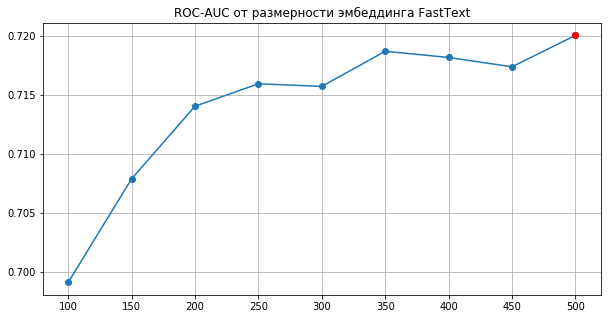

In [159]:
plt.plot(grid, res, 'o-')
plt.grid()
plt.title('ROC-AUC от размерности эмбеддинга FastText')
plt.plot(grid[np.argmax(res)], np.max(res), 'ro')

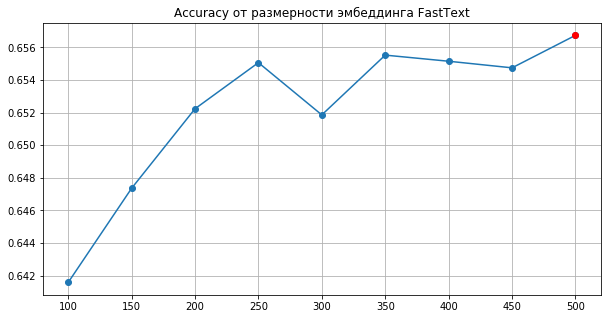

In [160]:
plt.plot(grid, res2, 'o-')
plt.grid()
plt.title('Accuracy от размерности эмбеддинга FastText')
plt.plot(grid[np.argmax(res2)], np.max(res2), 'ro')

### Оптимальная размерность = 500

In [14]:
model = FastText(sentences_ted, size=500, window=5, min_count=1, workers=4,sg=1, seed=1)
ft_dictn = dict(zip(model.wv.index2word, model.wv.vectors))

In [21]:
X_tr_ft = transform(X_train['english'], ft_dictn, 500)
X_test_ft = transform(X_test['english'], ft_dictn, 500)

100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:03<00:00, 10839.18it/s]


*** Logistic Regression***

In [167]:
scaler = StandardScaler()

X_ft_train_sc = scaler.fit_transform(X_tr_ft)
X_ft_test_sc = scaler.transform(X_test_ft)

In [168]:
ft_lr_true = LogisticRegression(random_state=0)
FT_LR_true = GridSearchCV(ft_lr_true, {'C': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 10]},
                      verbose=1, scoring='roc_auc', cv=3)
FT_LR_true.fit(X_ft_train_sc, y_train)
ft_lr_true_predict = FT_LR_true.best_estimator_.predict_proba(X_ft_test_sc)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

In [169]:
ft_lr_acc = accuracy_score(y_test,  FT_LR_true.best_estimator_.predict(X_ft_test_sc))
ft_lr_acc

0.6390957907500433

In [170]:
ft_lr_roc = roc_auc_score(y_test, ft_lr_true_predict[:,1])
ft_lr_roc

0.6864894217363402

*** XGBoost***

In [171]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, learning_rate=0.03, max_depth=4, seed = 42,
                  eval_metric='auc')
xgb.fit(X_tr_ft, y_train, eval_set=[(X_test_ft, y_test)], early_stopping_rounds=50,verbose=250)

[0]	validation_0-auc:0.580924
Will train until validation_0-auc hasn't improved in 50 rounds.
[250]	validation_0-auc:0.678176
[500]	validation_0-auc:0.691365
[750]	validation_0-auc:0.69804
[1000]	validation_0-auc:0.702159
[1250]	validation_0-auc:0.704491
[1500]	validation_0-auc:0.70644
[1750]	validation_0-auc:0.707986
[2000]	validation_0-auc:0.708938
[2250]	validation_0-auc:0.709757
[2500]	validation_0-auc:0.710425
[2750]	validation_0-auc:0.711109
[3000]	validation_0-auc:0.711814
[3250]	validation_0-auc:0.712313
Stopping. Best iteration:
[3342]	validation_0-auc:0.712478



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=7, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [172]:
ft_xgb_predict = xgb.predict_proba(X_test_ft)

In [173]:
ft_xgb_acc = accuracy_score(y_test, xgb.predict(X_test_ft))
ft_xgb_acc

0.6506149315780357

In [174]:
ft_xgb_roc = roc_auc_score(y_test, ft_xgb_predict[:,1])
ft_xgb_roc

0.7124272116170255

***LightGBM***

In [175]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_ft, label=y_train), valid_sets=lgb.Dataset(X_test_ft, label=y_test),
              early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)
ft_lgb_roc = roc_auc_score(y_test, model.predict(X_test_ft))
ft_lgb_acc = accuracy_score(y_test, model.predict(X_test_ft)>0.5)

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's auc: 0.685163
[1000]	valid_0's auc: 0.697833
[1500]	valid_0's auc: 0.704393
[2000]	valid_0's auc: 0.708754
[2500]	valid_0's auc: 0.71187
[3000]	valid_0's auc: 0.714065
[3500]	valid_0's auc: 0.715616
[4000]	valid_0's auc: 0.717027
[4500]	valid_0's auc: 0.717921
[5000]	valid_0's auc: 0.718841
[5500]	valid_0's auc: 0.719451
Early stopping, best iteration is:
[5579]	valid_0's auc: 0.719581


In [138]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_ft, label=y_train), valid_sets=lgb.Dataset(X_test_ft, label=y_test),
              early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)
ft_lgb_roc = roc_auc_score(y_test, model.predict(X_test_ft))
ft_lgb_acc = accuracy_score(y_test, model.predict(X_test_ft)>0.5)

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's auc: 0.683963
[1000]	valid_0's auc: 0.696648
[1500]	valid_0's auc: 0.703895
[2000]	valid_0's auc: 0.708038
[2500]	valid_0's auc: 0.711119
[3000]	valid_0's auc: 0.713094
[3500]	valid_0's auc: 0.714717
[4000]	valid_0's auc: 0.715993
[4500]	valid_0's auc: 0.716984
[5000]	valid_0's auc: 0.717741
[5500]	valid_0's auc: 0.718326
Early stopping, best iteration is:
[5474]	valid_0's auc: 0.718359


In [ ]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_ft, label=y_train), valid_sets=lgb.Dataset(X_test_ft, label=y_test),
              early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)
ft_lgb_roc = roc_auc_score(y_test, model.predict(X_test_ft))
ft_lgb_acc = accuracy_score(y_test, model.predict(X_test_ft)>0.5)

In [176]:
print('ROC-AUC  = {:.5}\nAccuracy = {:.5}'.format(ft_lgb_roc, ft_lgb_acc))

ROC-AUC  = 0.71958
Accuracy = 0.65486


In [139]:
joblib.dump(model,'non_lingv/ft_500_non_lingv_lgb')

['non_lingv/ft_500_non_lingv_lgb']

In [19]:
ff=joblib.load('non_lingv/ft_500_non_lingv_lgb')
roc_auc_score(y_train, ff.predict(X_tr_ft))

0.612450662419624

## TF-IDF

In [22]:
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=400, max_df=0.4, use_idf=True)

In [23]:
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train['english'])
X_train_tfidf.shape

(138550, 1236)

In [24]:
X_test_tfidf = vectorizer_tfidf.transform(X_test['english'])
X_test_tfidf.shape

(34638, 1236)

In [25]:
X_train_tfidf

<138550x1236 sparse matrix of type '<class 'numpy.float64'>'
	with 1817327 stored elements in Compressed Sparse Row format>

In [26]:
scaler = StandardScaler(with_mean=False)

X_tfidf_train_sc = scaler.fit_transform(X_train_tfidf)
X_tfidf_test_sc = scaler.transform(X_test_tfidf)

In [134]:
tfidf_lr_true = LogisticRegression(random_state=0)
TFIDF_LR_true = GridSearchCV(tfidf_lr_true, {'C': [0.001, 0.01, 0.03, 0.1, 0.5, 1, 1.5, 10]},
                      verbose=1, scoring='roc_auc', cv=3)
TFIDF_LR_true.fit(X_tfidf_train_sc, y_train)

tfidf_lr_true_predict = TFIDF_LR_true.best_estimator_.predict_proba(X_tfidf_test_sc)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

In [135]:
tfidf_lr_acc = accuracy_score(y_test, TFIDF_LR_true.best_estimator_.predict(X_tfidf_test_sc))
tfidf_lr_acc

0.6488538599226283

In [136]:
tfidf_lr_roc = roc_auc_score(y_test, tfidf_lr_true_predict[:,1])
tfidf_lr_roc

0.70856016491485

In [137]:
joblib.dump(TFIDF_LR_true.best_estimator_,'non_lingv/tfidf_lr_non_lingv_3')

['non_lingv/tfidf_lr_non_lingv_3']

*** XGBoost***

In [138]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, learning_rate=0.1, max_depth=5, seed = 42,
                  eval_metric='auc')
xgb.fit(X_train_tfidf, y_train, eval_set=[(X_test_tfidf, y_test)], early_stopping_rounds=50,verbose=200)

[0]	validation_0-auc:0.571924
Will train until validation_0-auc hasn't improved in 50 rounds.
[200]	validation_0-auc:0.691051
[400]	validation_0-auc:0.703739
[600]	validation_0-auc:0.709175
[800]	validation_0-auc:0.71171
[1000]	validation_0-auc:0.713221
[1200]	validation_0-auc:0.713901
Stopping. Best iteration:
[1157]	validation_0-auc:0.713987



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=7, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [139]:
tfidf_xgb_predict = xgb.predict_proba(X_test_tfidf)

In [140]:
tfidf_xgb_acc = accuracy_score(y_test, xgb.predict(X_test_tfidf))
tfidf_xgb_acc

0.6502107511981061

In [141]:
tfidf_xgb_roc = roc_auc_score(y_test, tfidf_xgb_predict[:,1])
tfidf_xgb_roc

0.713883038453486

*** LightGBM***

In [144]:
model = lgb.train(lgb_params, lgb.Dataset(X_train_tfidf, label=y_train), valid_sets=lgb.Dataset(X_test_tfidf, label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 250)

Training until validation scores don't improve for 50 rounds.
[250]	valid_0's auc: 0.670152
[500]	valid_0's auc: 0.687575
[750]	valid_0's auc: 0.699363
[1000]	valid_0's auc: 0.706401
[1250]	valid_0's auc: 0.711012
[1500]	valid_0's auc: 0.713729
[1750]	valid_0's auc: 0.715564
[2000]	valid_0's auc: 0.717
[2250]	valid_0's auc: 0.717968
[2500]	valid_0's auc: 0.718679
[2750]	valid_0's auc: 0.719148
[3000]	valid_0's auc: 0.71952
Early stopping, best iteration is:
[3105]	valid_0's auc: 0.719646


In [145]:
tfidf_lgb_acc = accuracy_score(y_test, model.predict(X_test_tfidf)>0.5)
tfidf_lgb_acc

0.6545412552687799

In [146]:
tfidf_lgb_roc = roc_auc_score(y_test, model.predict(X_test_tfidf))
tfidf_lgb_roc

0.7196457569156517

In [147]:
joblib.dump(model,'non_lingv/tfidf_lgb_non_lingv3')

['non_lingv/tfidf_lgb_non_lingv3']

## Word2Vec

In [11]:
texts_stemmed = filter(None, [next_text.strip(' ').split(' ') for next_text \
                              in train_data['english'].append(train_data['translated'])])

In [12]:
w2v = Word2Vec(texts_stemmed, size=100, window=5, min_count=5, workers=4, seed=123)

In [200]:
%%time
X_tr_w2v = transform(X_train['english'], w2v, 100)
X_test_w2v = transform(X_test['english'], w2v, 100)

  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:08<00:00, 4170.12it/s]


Wall time: 40.1 s


In [201]:
X_tr_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
36619,0.000221,0.000774,0.000349,0.000087,0.000798,-0.000118,0.000002,0.000663,-0.000360,-0.000850,...,0.000593,-0.000044,-0.001028,-0.000491,0.000073,-0.000427,0.000133,-0.000433,0.000731,-0.000359
37827,0.000196,0.000499,0.000037,0.000253,0.001065,0.001279,0.000336,-0.000168,-0.000783,0.000287,...,-0.000348,0.000416,-0.000449,0.000132,-0.000766,-0.000776,0.000289,0.000689,-0.000106,-0.000414
44099,-0.001464,0.000098,0.000392,0.000219,0.000751,0.001097,0.000605,-0.000460,-0.000799,-0.000233,...,0.000101,-0.000062,-0.001260,0.000569,0.001074,0.001293,-0.000182,0.000234,0.000280,-0.000277
116443,0.000714,-0.000242,-0.000033,-0.000790,0.000470,0.001217,0.000213,0.000112,-0.000322,-0.000280,...,0.001281,-0.001243,-0.000416,0.001008,0.000380,-0.000207,-0.000908,-0.000565,0.000414,-0.000488
85368,-0.000295,-0.000867,0.000174,0.000063,0.000798,0.000328,0.000099,0.000165,-0.001021,-0.000593,...,0.000768,0.000192,-0.000112,0.000640,-0.000676,0.000049,0.000066,-0.000230,0.000610,-0.000446


*** Logistic Regression***

In [202]:
scaler = StandardScaler(with_mean=False)

X_w2v_train_sc = scaler.fit_transform(X_tr_w2v)
X_w2v_test_sc = scaler.transform(X_test_w2v)

In [203]:
w2v_lr_true = LogisticRegression(random_state=0)
w2v_LR_true = GridSearchCV(w2v_lr_true, {'C': [0.001, 0.01, 0.03, 0.1, 0.5, 1, 1.5, 10]},
                      verbose=1, scoring='roc_auc', cv=3)
w2v_LR_true.fit(X_w2v_train_sc, y_train)

w2v_lr_true_predict = w2v_LR_true.best_estimator_.predict_proba(X_w2v_test_sc)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

In [206]:
w2v_lr_acc = accuracy_score(y_test, w2v_LR_true.best_estimator_.predict(X_w2v_test_sc))
w2v_lr_acc

0.5861770310064092

In [207]:
w2v_lr_roc = roc_auc_score(y_test, w2v_lr_true_predict[:,1])
w2v_lr_roc

0.6180421963543179

*** XGBoost***

In [209]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, learning_rate=0.03, max_depth=4, seed = 42,
                  eval_metric='auc')
xgb.fit(X_tr_w2v, y_train, eval_set=[(X_test_w2v, y_test)], early_stopping_rounds=50,verbose=150)

[0]	validation_0-auc:0.579898
Will train until validation_0-auc hasn't improved in 50 rounds.
[150]	validation_0-auc:0.633296
[300]	validation_0-auc:0.643055
[450]	validation_0-auc:0.647706
[600]	validation_0-auc:0.650672
[750]	validation_0-auc:0.652789
[900]	validation_0-auc:0.654339
[1050]	validation_0-auc:0.655541
[1200]	validation_0-auc:0.656664
[1350]	validation_0-auc:0.657331
[1500]	validation_0-auc:0.658067
[1650]	validation_0-auc:0.658663
[1800]	validation_0-auc:0.659334
[1950]	validation_0-auc:0.659707
[2100]	validation_0-auc:0.66029
[2250]	validation_0-auc:0.660698
[2400]	validation_0-auc:0.66105
Stopping. Best iteration:
[2417]	validation_0-auc:0.661177



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=7, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [210]:
w2v_xgb_predict = xgb.predict_proba(X_test_w2v)

In [211]:
w2v_xgb_acc = accuracy_score(y_test, xgb.predict(X_test_w2v))
w2v_xgb_acc

0.6135746867602055

In [212]:
w2v_xgb_roc = roc_auc_score(y_test, w2v_xgb_predict[:,1])
w2v_xgb_roc

0.6611529915704222

*** LightGBM***

In [213]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_w2v, label=y_train), valid_sets=lgb.Dataset(X_test_w2v, label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 150)

Training until validation scores don't improve for 50 rounds.
[150]	valid_0's auc: 0.634257
[300]	valid_0's auc: 0.640557
[450]	valid_0's auc: 0.645806
[600]	valid_0's auc: 0.649709
[750]	valid_0's auc: 0.652856
[900]	valid_0's auc: 0.65535
[1050]	valid_0's auc: 0.657469
[1200]	valid_0's auc: 0.659081
[1350]	valid_0's auc: 0.660471
[1500]	valid_0's auc: 0.661663
[1650]	valid_0's auc: 0.662729
[1800]	valid_0's auc: 0.663621
[1950]	valid_0's auc: 0.664501
[2100]	valid_0's auc: 0.665251
[2250]	valid_0's auc: 0.665759
[2400]	valid_0's auc: 0.666385
[2550]	valid_0's auc: 0.666984
[2700]	valid_0's auc: 0.667552
[2850]	valid_0's auc: 0.668059
[3000]	valid_0's auc: 0.668702
[3150]	valid_0's auc: 0.669155
[3300]	valid_0's auc: 0.669581
[3450]	valid_0's auc: 0.669875
[3600]	valid_0's auc: 0.670363
[3750]	valid_0's auc: 0.670695
[3900]	valid_0's auc: 0.670879
[4050]	valid_0's auc: 0.67114
[4200]	valid_0's auc: 0.671461
[4350]	valid_0's auc: 0.671787
[4500]	valid_0's auc: 0.672041
[4650]	valid_0's

In [214]:
w2v_lgb_acc = accuracy_score(y_test, model.predict(X_test_w2v)>0.5)
w2v_lgb_acc

0.6220336047115884

In [215]:
w2v_lgb_roc = roc_auc_score(y_test, model.predict(X_test_w2v))
w2v_lgb_roc

0.6735508304060986

*** Подбор размерности***

In [216]:
nums = []
res = []
res2 = []
grid = np.arange(100,550,50)
for i in grid:
    nums.append(i)
    texts_stemmed = filter(None, [next_text.strip(' ').split(' ') for next_text \
                              in X_train['english'].append(X_test['english'])])
    w2v = Word2Vec(texts_stemmed, size=i, window=5, min_count=5, workers=4, seed=123)
    X_tr_w2v = transform(X_train['english'], w2v, i)
    X_test_w2v = transform(X_test['english'], w2v, i)
    model = lgb.train(lgb_params, lgb.Dataset(X_tr_w2v, label=y_train), valid_sets=lgb.Dataset(X_test_w2v, label=y_test),
                      early_stopping_rounds=50, num_boost_round=10000,  verbose_eval = False)
    res.append(roc_auc_score(y_test, model.predict(X_test_w2v)))
    res2.append(accuracy_score(y_test, model.predict(X_test_w2v)>0.5))
    print('Размерность: {} AUC = {:.5} Acc = {:.5}'.format(i,roc_auc_score(y_test, model.predict(X_test_w2v)), \
                                                     accuracy_score(y_test, model.predict(X_test_w2v)>0.5)))

  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:08<00:00, 3894.86it/s]


Размерность: 100 AUC = 0.67355 Acc = 0.62203


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:10<00:00, 3428.15it/s]


Размерность: 150 AUC = 0.68478 Acc = 0.62795


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:09<00:00, 3842.59it/s]


Размерность: 200 AUC = 0.69646 Acc = 0.63832


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:09<00:00, 3821.80it/s]


Размерность: 250 AUC = 0.69856 Acc = 0.63985


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:09<00:00, 3767.42it/s]


Размерность: 300 AUC = 0.70356 Acc = 0.64244


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:09<00:00, 3776.36it/s]


Размерность: 350 AUC = 0.70871 Acc = 0.64729


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:09<00:00, 3840.19it/s]


Размерность: 400 AUC = 0.7113 Acc = 0.64862


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:08<00:00, 4043.29it/s]


Размерность: 450 AUC = 0.71377 Acc = 0.6522


  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:08<00:00, 4022.54it/s]


Размерность: 500 AUC = 0.71569 Acc = 0.65064


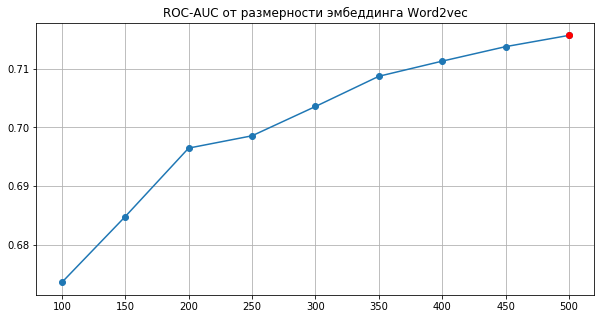

In [217]:
plt.plot(grid, res, 'o-')
plt.grid()
plt.title('ROC-AUC от размерности эмбеддинга Word2vec')
plt.plot(grid[np.argmax(res)], np.max(res), 'ro')

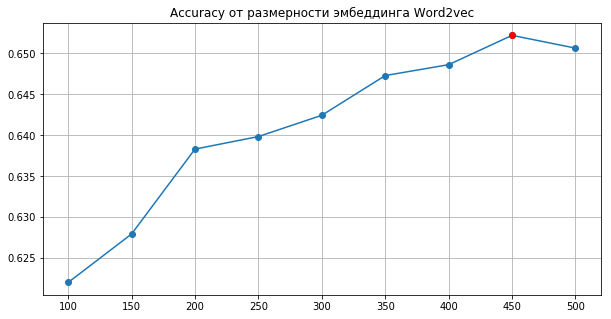

In [218]:
plt.plot(grid, res2, 'o-')
plt.grid()
plt.title('Accuracy от размерности эмбеддинга Word2vec')
plt.plot(grid[np.argmax(res2)], np.max(res2), 'ro')

### Оптимальная размерность = 500

In [34]:
texts_stemmed = filter(None, [next_text.strip(' ').split(' ') for next_text \
                              in X_train['english'].append(X_test['english'])])
w2v = Word2Vec(texts_stemmed, size=500, window=5, min_count=5, workers=4, seed=123)

In [35]:
X_tr_w2v = transform(X_train['english'], w2v, 500)
X_test_w2v = transform(X_test['english'], w2v, 500)

  0%|                                                                                       | 0/138550 [00:00<?, ?it/s]C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\vaski\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
100%|██████████████████████████████████████████████████████████████████████████| 34638/34638 [00:16<00:00, 2041.64it/s]


*** Logistic Regression***

In [221]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_tr_w2v)
X_test_sc = scaler.transform(X_test_w2v)

In [222]:
w2v_lr = LogisticRegression(random_state=0)
w2v_lr_true = GridSearchCV(w2v_lr, {'C': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 10]},
                      verbose=1, scoring='roc_auc', cv=3)
w2v_lr_true.fit(X_train_sc, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [228]:
w2v_lr_acc = accuracy_score(y_test, w2v_lr_true.best_estimator_.predict(X_test_sc))
w2v_lr_acc

0.6193198221606329

In [229]:
w2v_lr_roc = roc_auc_score(y_test,  w2v_lr_true.best_estimator_.predict_proba(X_test_sc)[:,1])
w2v_lr_roc

0.6639918625696959

*** XGBoost***

In [230]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, learning_rate=0.03, max_depth=4, seed = 42,
                  eval_metric='auc')
xgb.fit(X_tr_w2v, y_train, eval_set=[(X_test_w2v, y_test)], early_stopping_rounds=50,verbose=250)

[0]	validation_0-auc:0.589458
Will train until validation_0-auc hasn't improved in 50 rounds.
[250]	validation_0-auc:0.66695
[500]	validation_0-auc:0.680672
[750]	validation_0-auc:0.687955
[1000]	validation_0-auc:0.692278
[1250]	validation_0-auc:0.695509
[1500]	validation_0-auc:0.697614
[1750]	validation_0-auc:0.699501
[2000]	validation_0-auc:0.700814
[2250]	validation_0-auc:0.701811
[2500]	validation_0-auc:0.70252
[2750]	validation_0-auc:0.703315
[3000]	validation_0-auc:0.703896
[3250]	validation_0-auc:0.704551
[3500]	validation_0-auc:0.705082
[3750]	validation_0-auc:0.705491
[4000]	validation_0-auc:0.705932
[4250]	validation_0-auc:0.706394
Stopping. Best iteration:
[4358]	validation_0-auc:0.706524



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=7, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [231]:
w2v_xgb_predict = xgb.predict_proba(X_test_w2v)

In [232]:
w2v_xgb_acc = accuracy_score(y_test, xgb.predict(X_test_w2v))
w2v_xgb_acc

0.6466308678330157

In [233]:
w2v_xgb_roc = roc_auc_score(y_test, w2v_xgb_predict[:,1])
w2v_xgb_roc

0.7064991543644161

***LightGBM***

In [234]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_w2v, label=y_train), valid_sets=lgb.Dataset(X_test_w2v, label=y_test),
              early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)
w2v_lgb_roc = roc_auc_score(y_test, model.predict(X_test_w2v))
w2v_lgb_acc = accuracy_score(y_test, model.predict(X_test_w2v)>0.5)

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's auc: 0.67243
[1000]	valid_0's auc: 0.68653
[1500]	valid_0's auc: 0.694724
[2000]	valid_0's auc: 0.700031
[2500]	valid_0's auc: 0.703792
[3000]	valid_0's auc: 0.706502
[3500]	valid_0's auc: 0.708721
[4000]	valid_0's auc: 0.710533
[4500]	valid_0's auc: 0.711811
[5000]	valid_0's auc: 0.713101
[5500]	valid_0's auc: 0.713988
[6000]	valid_0's auc: 0.714746
[6500]	valid_0's auc: 0.715503
Early stopping, best iteration is:
[6698]	valid_0's auc: 0.715691


In [141]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_w2v, label=y_train), valid_sets=lgb.Dataset(X_test_w2v, label=y_test),
              early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)
w2v_lgb_roc = roc_auc_score(y_test, model.predict(X_test_w2v))
w2v_lgb_acc = accuracy_score(y_test, model.predict(X_test_w2v)>0.5)

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's auc: 0.67403
[1000]	valid_0's auc: 0.688628
[1500]	valid_0's auc: 0.696732
[2000]	valid_0's auc: 0.702676
[2500]	valid_0's auc: 0.706532
[3000]	valid_0's auc: 0.7094
[3500]	valid_0's auc: 0.711667
[4000]	valid_0's auc: 0.713756
[4500]	valid_0's auc: 0.715151
[5000]	valid_0's auc: 0.716216
[5500]	valid_0's auc: 0.716994
[6000]	valid_0's auc: 0.717818
Early stopping, best iteration is:
[6340]	valid_0's auc: 0.718395


In [235]:
print('ROC-AUC  = {:.5}\nAccuracy = {:.5}'.format(w2v_lgb_roc, w2v_lgb_acc))

ROC-AUC  = 0.71569
Accuracy = 0.65064


In [39]:
joblib.dump(model,'non_lingv/w2v_500_non_lingv')

['non_lingv/w2v_500_non_lingv0106']

### Doc2Vec

In [33]:
sentences_ted = []
for sent_str in train_data['english'].append(train_data['translated']):
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences_ted)]

In [240]:
doc2_vec_model = Doc2Vec(documents, vector_size=100, window=2, min_count=3, workers=4)
d2v_100 = dict(zip(doc2_vec_model.wv.index2word, doc2_vec_model.wv.vectors))

In [241]:
%%time
X_train_d2v = transform(X_train['english'], d2v_100, 100)
X_test_d2v = transform(X_test['english'], d2v_100, 100)

100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 17975.30it/s]


Wall time: 9.11 s


In [242]:
X_train_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
36619,0.582770,-0.228411,0.230542,0.246905,-0.759270,-0.006799,0.222018,-0.008826,0.133640,-0.432107,...,-0.130981,-0.586272,-0.195841,-0.565758,-0.053315,0.246474,-0.528189,0.159696,0.557770,-0.187350
37827,0.233054,-0.354811,0.297219,0.318084,-0.466437,0.386971,0.278866,-0.088298,0.153572,-0.472706,...,-0.715920,-0.293807,-0.032905,-0.538681,0.404714,0.188675,-0.357244,-0.089808,0.407331,-0.048564
44099,0.258539,0.127574,0.081522,0.491937,0.046118,0.471275,0.583606,0.010487,0.310341,-0.698960,...,-0.652620,-0.206122,0.049780,-0.207561,0.680276,0.763932,-0.131194,0.011349,0.340236,0.181285
116443,0.064818,-0.033338,0.225773,0.043258,-0.142517,0.234802,-0.135343,0.465382,0.085760,-0.229886,...,-0.558055,-0.827503,-0.197363,-0.786588,0.498885,0.168873,-0.260345,0.182580,0.295051,0.042339
85368,0.190382,-0.032938,0.251465,0.677580,-0.450188,0.432807,0.092398,0.059022,0.033453,-0.246604,...,-0.466938,-0.936319,-0.013662,-0.902388,0.560215,0.602744,0.036974,-0.029773,0.298579,0.421649


*** Logistic Regression***

In [243]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train_d2v)
X_test_sc = scaler.transform(X_test_d2v)

In [244]:
d2v_lr = LogisticRegression(random_state=0)
d2v_lr_true = GridSearchCV(d2v_lr, {'C': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 10]},
                      verbose=1, scoring='roc_auc', cv=3)
d2v_lr_true.fit(X_train_sc, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [246]:
d2v_lr_true_predict = d2v_lr_true.best_estimator_.predict_proba(X_test_sc)

In [247]:
d2v_lr_acc = accuracy_score(y_test, d2v_lr_true.best_estimator_.predict(X_test_sc))
d2v_lr_acc

0.6087533922281887

In [248]:
d2v_lr_roc = roc_auc_score(y_test, d2v_lr_true_predict[:,1])
d2v_lr_roc

0.647684746344881

*** XGBoost***

In [250]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, learning_rate=0.03, max_depth=7, seed = 42,
                  eval_metric='auc')
xgb.fit(X_train_d2v, y_train, eval_set=[(X_test_d2v, y_test)], early_stopping_rounds=50,verbose=150)

[0]	validation_0-auc:0.623858
Will train until validation_0-auc hasn't improved in 50 rounds.
[150]	validation_0-auc:0.683216
[300]	validation_0-auc:0.689963
[450]	validation_0-auc:0.692521
[600]	validation_0-auc:0.694218
[750]	validation_0-auc:0.695068
[900]	validation_0-auc:0.695699
[1050]	validation_0-auc:0.695872
Stopping. Best iteration:
[1005]	validation_0-auc:0.696096



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=7, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [251]:
d2v_xgb_predict = xgb.predict_proba(X_test_d2v)

In [254]:
d2v_xgb_acc = accuracy_score(y_test, xgb.predict(X_test_d2v))
d2v_xgb_acc

0.6393267509671459

In [255]:
d2v_xgb_roc = roc_auc_score(y_test, d2v_xgb_predict[:,1])
d2v_xgb_roc

0.6958755744804508

*** LightGBM***

In [256]:
model = lgb.train(lgb_params, lgb.Dataset(X_train_d2v, label=y_train), valid_sets=lgb.Dataset(X_test_d2v, label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 50)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.661055
[100]	valid_0's auc: 0.664827
[150]	valid_0's auc: 0.66793
[200]	valid_0's auc: 0.669763
[250]	valid_0's auc: 0.672139
[300]	valid_0's auc: 0.67431
[350]	valid_0's auc: 0.676266
[400]	valid_0's auc: 0.678132
[450]	valid_0's auc: 0.679524
[500]	valid_0's auc: 0.68079
[550]	valid_0's auc: 0.682045
[600]	valid_0's auc: 0.683249
[650]	valid_0's auc: 0.684247
[700]	valid_0's auc: 0.685276
[750]	valid_0's auc: 0.686081
[800]	valid_0's auc: 0.686885
[850]	valid_0's auc: 0.687654
[900]	valid_0's auc: 0.688381
[950]	valid_0's auc: 0.689067
[1000]	valid_0's auc: 0.689666
[1050]	valid_0's auc: 0.690284
[1100]	valid_0's auc: 0.690898
[1150]	valid_0's auc: 0.69144
[1200]	valid_0's auc: 0.691966
[1250]	valid_0's auc: 0.692425
[1300]	valid_0's auc: 0.692882
[1350]	valid_0's auc: 0.693229
[1400]	valid_0's auc: 0.693634
[1450]	valid_0's auc: 0.693991
[1500]	valid_0's auc: 0.694335
[1550]	valid_0's auc: 0.694729
[

In [257]:
d2v_lgb_acc = accuracy_score(y_test, model.predict(X_test_d2v)>0.5)
d2v_lgb_acc

0.6436283850106819

In [258]:
d2v_lgb_roc = roc_auc_score(y_test, model.predict(X_test_d2v))
d2v_lgb_roc

0.7011752039716008

*** Подбор размерности***

In [259]:
nums = []
res = []
res2 = []
grid = np.arange(100,550,50)
for i in grid:
    nums.append(i)
    doc2_vec_model = Doc2Vec(documents, vector_size=i, window=3, min_count=3, workers=4, seed=123)
    d2v = dict(zip(doc2_vec_model.wv.index2word, doc2_vec_model.wv.vectors))
    X_tr_d2v = transform(X_train['english'], d2v, i)
    X_test_d2v = transform(X_test['english'], d2v, i)
    model = lgb.train(lgb_params, lgb.Dataset(X_tr_d2v, label=y_train), valid_sets=lgb.Dataset(X_test_d2v, label=y_test),
                      early_stopping_rounds=50, num_boost_round=10000,  verbose_eval = False)
    res.append(roc_auc_score(y_test, model.predict(X_test_d2v)))
    res2.append(accuracy_score(y_test, model.predict(X_test_d2v)>0.5))
    print('Размерность: {} AUC = {:.5} Acc = {:.5}'.format(i,roc_auc_score(y_test, model.predict(X_test_d2v)), \
                                                     accuracy_score(y_test, model.predict(X_test_d2v)>0.5)))

100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 19523.00it/s]


Размерность: 100 AUC = 0.70329 Acc = 0.64487


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 18447.24it/s]


Размерность: 150 AUC = 0.70557 Acc = 0.6464


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 21285.34it/s]


Размерность: 200 AUC = 0.70585 Acc = 0.64753


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 20806.05it/s]


Размерность: 250 AUC = 0.70707 Acc = 0.64776


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 20401.09it/s]


Размерность: 300 AUC = 0.7071 Acc = 0.64911


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 19454.92it/s]


Размерность: 350 AUC = 0.70848 Acc = 0.64908


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 19824.63it/s]


Размерность: 400 AUC = 0.70879 Acc = 0.64949


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 19170.45it/s]


Размерность: 450 AUC = 0.70784 Acc = 0.64796


100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:01<00:00, 18957.25it/s]


Размерность: 500 AUC = 0.70696 Acc = 0.64767


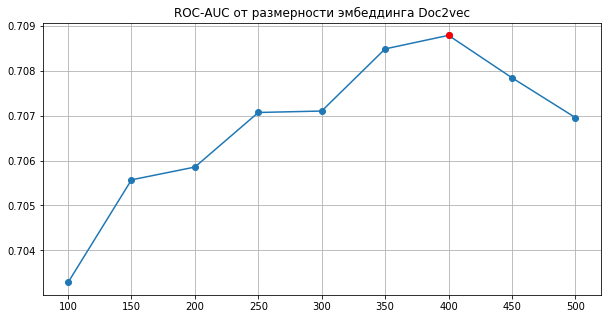

In [260]:
plt.plot(grid, res, 'o-')
plt.grid()
plt.title('ROC-AUC от размерности эмбеддинга Doc2vec')
plt.plot(grid[np.argmax(res)], np.max(res), 'ro')

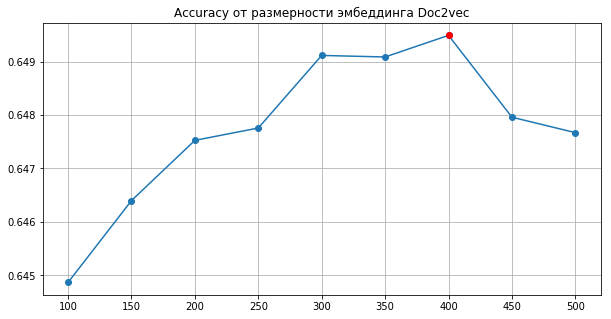

In [261]:
plt.plot(grid, res2, 'o-')
plt.grid()
plt.title('Accuracy от размерности эмбеддинга Doc2vec')
plt.plot(grid[np.argmax(res2)], np.max(res2), 'ro')

### Оптимальная размерность = 400

In [34]:
doc2_vec_model = Doc2Vec(documents, vector_size=400, window=3, min_count=3, workers=4, seed=123)
d2v = dict(zip(doc2_vec_model.wv.index2word, doc2_vec_model.wv.vectors))

In [35]:
X_tr_d2v = transform(X_train['english'], d2v, 400)
X_test_d2v = transform(X_test['english'], d2v, 400)

100%|█████████████████████████████████████████████████████████████████████████| 34638/34638 [00:03<00:00, 10964.56it/s]


*** Logistic Regression***

In [264]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_tr_d2v)
X_test_sc = scaler.transform(X_test_d2v)

In [267]:
d2v_lr = LogisticRegression(random_state=0, n_jobs=6)
d2v_lr_true = GridSearchCV(d2v_lr, {'C': [0.001, 0.01, 0.03, 0.05, 0.1, 0.5, 1]},
                      verbose=1, scoring='roc_auc', cv=3)
d2v_lr_true.fit(X_train_sc, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=6,
          penalty='l2', random_state=0, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.03, 0.05, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [268]:
d2v_lr_acc = accuracy_score(y_test, d2v_lr_true.best_estimator_.predict(X_test_sc))
d2v_lr_acc

0.6278364801662913

In [269]:
d2v_lr_roc = roc_auc_score(y_test,  d2v_lr_true.best_estimator_.predict_proba(X_test_sc)[:,1])
d2v_lr_roc

0.6720209023330566

*** XGBoost***

In [270]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, learning_rate=0.03, max_depth=4, seed = 42,
                  eval_metric='auc')
xgb.fit(X_tr_d2v, y_train, eval_set=[(X_test_d2v, y_test)], early_stopping_rounds=50,verbose=250)

[0]	validation_0-auc:0.612389
Will train until validation_0-auc hasn't improved in 50 rounds.
[250]	validation_0-auc:0.6836
[500]	validation_0-auc:0.691068
[750]	validation_0-auc:0.694515
[1000]	validation_0-auc:0.69652
[1250]	validation_0-auc:0.698283
[1500]	validation_0-auc:0.699343
Stopping. Best iteration:
[1653]	validation_0-auc:0.699733



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=7, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [271]:
d2v_xgb_predict = xgb.predict_proba(X_test_d2v)

In [272]:
d2v_xgb_acc = accuracy_score(y_test, xgb.predict(X_test_d2v))
d2v_xgb_acc

0.6425024539523068

In [273]:
d2v_xgb_roc = roc_auc_score(y_test, d2v_xgb_predict[:,1])
d2v_xgb_roc

0.699702524200539

***LightGBM***

In [143]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr_d2v, label=y_train), valid_sets=lgb.Dataset(X_test_d2v, label=y_test),
              early_stopping_rounds=100, num_boost_round=10000, verbose_eval = 500)
d2v_lgb_roc = roc_auc_score(y_test, model.predict(X_test_d2v))
d2v_lgb_acc = accuracy_score(y_test, model.predict(X_test_d2v)>0.5)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's auc: 0.68818
[1000]	valid_0's auc: 0.696529
[1500]	valid_0's auc: 0.701135
[2000]	valid_0's auc: 0.703802
[2500]	valid_0's auc: 0.705519
[3000]	valid_0's auc: 0.706816
[3500]	valid_0's auc: 0.707686
[4000]	valid_0's auc: 0.708398
[4500]	valid_0's auc: 0.70901
Early stopping, best iteration is:
[4890]	valid_0's auc: 0.709334


In [275]:
print('ROC-AUC  = {:.5}\nAccuracy = {:.5}'.format(d2v_lgb_roc, d2v_lgb_acc))

ROC-AUC  = 0.70951
Accuracy = 0.652


In [144]:
joblib.dump(model,'non_lingv/d2v_400_non_lingv_lgb')

['non_lingv/d2v_400_non_lingv_lgb']

## Результаты без лингвистических

In [277]:
df_results = pd.DataFrame(columns=["Embedding", "Model", "Accuracy", "ROC-AUC"], index=np.arange(12))

In [149]:
for i in range(3):
df_results.loc[:2] = "FastText"
df_results.loc[3:5] = "TF-IDF"
df_results.loc[6:8] = "Word2Vec"
df_results.loc[9:11] = "Doc2Vec"
for i in range(12):
    if i%3 == 0:
        df_results.iloc[i][1] = "Logistic Regression"
    elif i%3 == 1:
        df_results.iloc[i][1] = " XGboost"
    elif i%3 == 2:
        df_results.iloc[i][1] = " LightGBM"
def func_to_print(ft_lr_acc,ft_lr_roc, ft_xgb_acc, ft_xgb_roc, ft_lgb_acc,ft_lgb_roc, start=0, end=2):
    df_results.iloc[start][2] = round(ft_lr_acc,4)
    df_results.iloc[start][3] = round(ft_lr_roc,4)
    df_results.iloc[start+1][2] = round(ft_xgb_acc,4)
    df_results.iloc[start+1][3] = round(ft_xgb_roc,4)
    df_results.iloc[end][2] = round(ft_lgb_acc,4)
    df_results.iloc[end][3] = round(ft_lgb_roc,4)
    
func_to_print(ft_lr_acc,ft_lr_roc, ft_xgb_acc, ft_xgb_roc, ft_lgb_acc,ft_lgb_roc, start=0, end=2)

func_to_print(tfidf_lr_acc,tfidf_lr_roc, tfidf_xgb_acc, tfidf_xgb_roc, tfidf_lgb_acc, tfidf_lgb_roc, start=3, end=5)

func_to_print(w2v_lr_acc, w2v_lr_roc, w2v_xgb_acc, w2v_xgb_roc, w2v_lgb_acc, w2v_lgb_roc, start=6, end=8)

func_to_print(d2v_lr_acc, d2v_lr_roc, d2v_xgb_acc, d2v_xgb_roc, d2v_lgb_acc, d2v_lgb_roc, start=9, end=11)

In [150]:
df_results

,Embedding,Model,Accuracy,ROC-AUC
0,FastText,Logistic Regression,0.6391,0.6865
1,FastText,XGboost,0.6506,0.7124
2,FastText,LightGBM,0.6549,0.7196
3,TF-IDF,Logistic Regression,0.6489,0.7086
4,TF-IDF,XGboost,0.6502,0.7139
5,TF-IDF,LightGBM,0.6545,0.7196
6,Word2Vec,Logistic Regression,0.6193,0.664
7,Word2Vec,XGboost,0.6466,0.7065
8,Word2Vec,LightGBM,0.6506,0.7157
9,Doc2Vec,Logistic Regression,0.6278,0.672


In [151]:
df_results.to_pickle('non_lingv/df_results_non_lingv2')

In [13]:
df_results = pd.read_pickle('non_lingv/df_results_non_lingv2')

In [152]:
df_results.style.apply(lambda x: ['background: lightgreen' if x.name in [2,5,8,11]  else '' for i in x], axis=1)

,Embedding,Model,Accuracy,ROC-AUC
0,FastText,Logistic Regression,0.6391,0.6865
1,FastText,XGboost,0.6506,0.7124
2,FastText,LightGBM,0.6549,0.7196
3,TF-IDF,Logistic Regression,0.6489,0.7086
4,TF-IDF,XGboost,0.6502,0.7139
5,TF-IDF,LightGBM,0.6545,0.7196
6,Word2Vec,Logistic Regression,0.6193,0.664
7,Word2Vec,XGboost,0.6466,0.7065
8,Word2Vec,LightGBM,0.6506,0.7157
9,Doc2Vec,Logistic Regression,0.6278,0.672


In [153]:
res = pd.DataFrame(df_results.groupby(['Embedding', 'Model'])['Accuracy', 'ROC-AUC'].min())
res

Accuracy  ROC-AUC
Embedding Model                                 
Doc2Vec    LightGBM              0.6520   0.7095
           XGboost               0.6425   0.6997
          Logistic Regression    0.6278   0.6720
FastText   LightGBM              0.6549   0.7196
           XGboost               0.6506   0.7124
          Logistic Regression    0.6391   0.6865
TF-IDF     LightGBM              0.6545   0.7196
           XGboost               0.6502   0.7139
          Logistic Regression    0.6489   0.7086
Word2Vec   LightGBM              0.6506   0.7157
           XGboost               0.6466   0.7065
          Logistic Regression    0.6193   0.6640

In [154]:
res.style.apply(lambda x: ['background: lightgreen' if i==0.6823 or i == 0.7543 else '' for i in x], axis=1)

### Linguistic features

sentence
lengths, different tokens ratios, average word lengths,
ratios of numbers, brackets, quotation marks,
punctuation symbols and POS-tags and spell-checking
ratios

In [14]:
def ling_features(sent):
    features = {}
    features['n_words'] = len(text_to_word_sequence(sent))
    word_lens = [len(word) for word in text_to_word_sequence(sent)]
    features['avg_word_len'] = np.mean(word_lens) if len(word_lens) > 0 else 0
    features['n_dots'] = np.sum(np.array(list(sent)) == '.')
    features['n_commas'] = np.sum(np.array(list(sent)) == ',')
    features['n_excl'] = np.sum(np.array(list(sent)) == '!')
    features['n_questions'] = np.sum(np.array(list(sent)) == '?')
    features['n_colons'] = np.sum(np.array(list(sent)) == ':')
    features['n_semicolons'] = np.sum(np.array(list(sent)) == ';')
    features['n_quotes'] = np.sum(np.array(list(sent)) == "'") + np.sum(np.array(list(sent)) == "’")
    features['n_doublequotes'] = np.sum(np.array(list(sent)) == '"')
    features['n_open_brackets'] = np.sum(np.array(list(sent)) == '(')
    features['n_hyphens'] = np.sum(np.array(list(sent)) == '-')
    features['n_numbers'] = len(re.findall('\d+', sent))
    
    # POS tags
    for word, tag in nltk.pos_tag(nltk.tokenize.word_tokenize(sent)):
        if word.isalpha():
            features['n_tags_{}'.format(tag)] = features.get('n_tags_{}'.format(tag), 0) + 1
    
    return features

In [37]:
sent = train_data.loc[12200, 'english']
print(sent)
ling_features(sent)

To date , several hundred officials , including over 70 high - level officials in Fujian and elsewhere , have been arrested .


{'avg_word_len': 5.444444444444445,
 'n_colons': 0,
 'n_commas': 3,
 'n_dots': 1,
 'n_doublequotes': 0,
 'n_excl': 0,
 'n_hyphens': 1,
 'n_numbers': 1,
 'n_open_brackets': 0,
 'n_questions': 0,
 'n_quotes': 0,
 'n_semicolons': 0,
 'n_tags_CC': 1,
 'n_tags_CD': 1,
 'n_tags_IN': 2,
 'n_tags_JJ': 3,
 'n_tags_NN': 2,
 'n_tags_NNS': 2,
 'n_tags_RB': 1,
 'n_tags_TO': 1,
 'n_tags_VBG': 1,
 'n_tags_VBN': 2,
 'n_tags_VBP': 1,
 'n_words': 18}

In [16]:
X_train.head()

,english
36619,The EU s role in fostering productivity gains ...
37827,Once investors see that Brazil s fiscal policy...
44099,"Of course , not everyone in Europe can be expe..."
116443,Their silence on Iraq reflected their hunch un...
85368,"This is all the more regrettable now , because..."


In [327]:
X_list = list(X_train['english'])
X_lingv_train = pd.DataFrame()
for i, Xi in enumerate(X_list):
    X_lingv_train = X_lingv_train.append(ling_features(Xi), ignore_index=True)
    print('Progress: {}/{}'.format(i + 1, len(X_list)), end='\r')
print('Progress: {}/{}'.format(i + 1, len(X_list)))

X_lingv_train.index = X_train.index
X_lingv_train.head()

Progress: 138550/138550


,avg_word_len,n_colons,n_commas,n_dots,n_doublequotes,n_excl,n_hyphens,n_numbers,n_open_brackets,n_questions,...,n_tags_FW,n_tags_UH,n_tags_EX,n_tags_RP,n_tags_RBS,n_tags_SYM,n_tags_LS,n_tags_POS,n_tags_$,n_tags_''
36619,4.875000,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37827,5.153846,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44099,4.764706,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116443,5.580645,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85368,5.307692,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
X_list = list(X_test['english'])
X_lingv_test = pd.DataFrame()
for i, Xi in enumerate(X_list):
    X_lingv_test = X_lingv_test.append(ling_features(Xi), ignore_index=True)
    print('Progress: {}/{}'.format(i + 1, len(X_list)), end='\r')
print('Progress: {}/{}'.format(i + 1, len(X_list)))

X_lingv_test.index = X_test.index
X_lingv_test.head()

Progress: 34638/34638


,avg_word_len,n_colons,n_commas,n_dots,n_doublequotes,n_excl,n_hyphens,n_numbers,n_open_brackets,n_questions,...,n_tags_SYM,n_tags_JJS,n_tags_PDT,n_tags_WP$,n_tags_FW,n_tags_POS,n_tags_$,n_tags_UH,n_tags_LS,n_tags_''
23151,5.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8660,7.500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24930,4.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3580,4.375,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27158,4.250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [329]:
X_lingv_train.to_pickle('data/ling_features_train')
X_lingv_test.to_pickle('data/ling_features_test')

In [15]:
X_lingv_tr = pd.read_pickle('data/ling_features_train')
X_lingv_test = pd.read_pickle('data/ling_features_test')

In [16]:
X_lingv_tr.isna().sum()

avg_word_len            0
n_colons                0
n_commas                0
n_dots                  0
n_doublequotes          0
n_excl                  0
n_hyphens               0
n_numbers               0
n_open_brackets         0
n_questions             0
n_quotes                0
n_semicolons            0
n_tags_CC           66654
n_tags_DT           21620
n_tags_IN           19112
n_tags_JJ           27974
n_tags_MD          100045
n_tags_NN           13558
n_tags_NNP          55621
n_tags_NNS          43950
n_tags_RB           57805
n_tags_TO           80470
n_tags_VB           69128
n_tags_VBD          97499
n_tags_VBG         100049
n_words                 0
n_tags_PRP          94612
n_tags_RBR         131665
n_tags_VBP          96239
n_tags_VBZ          76662
n_tags_JJR         127970
n_tags_VBN          88688
n_tags_NNPS        131482
n_tags_PRP$        112493
n_tags_PDT         136393
n_tags_WDT         121258
n_tags_WP$         137909
n_tags_WP          129318
n_tags_JJS  

In [17]:
X_lingv_tr = X_lingv_tr[['avg_word_len','n_colons', 'n_commas','n_dots','n_doublequotes','n_excl',
                        'n_hyphens','n_numbers','n_open_brackets','n_questions','n_quotes','n_semicolons'         
,'n_tags_DT','n_tags_IN' ,'n_tags_JJ','n_tags_NN' ,'n_tags_NNS','n_words']]
X_lingv_test = X_lingv_test[X_lingv_tr.columns]

In [18]:
X_lingv_tr.shape, X_lingv_test.shape 

((138550, 18), (34638, 18))

In [19]:
X_lingv_tr.fillna(0, inplace=True)
X_lingv_test.fillna(0, inplace=True)

In [11]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_lingv_tr)
X_test_sc = scaler.transform(X_lingv_test)

In [297]:
lr_model = LogisticRegression(random_state=17)
clf_lr = GridSearchCV(lr_model, {'C': [0.001, 0.01, 0.03, 0.05, 0.1, 0.5, 1, 10, 50, 100]},
                      verbose=1, scoring='roc_auc', cv=3)
clf_lr.fit(X_train_sc, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vaski\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.03, 0.05, 0.1, 0.5, 1, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [298]:
print(clf_lr.best_score_)
print(clf_lr.best_params_)

0.581955675195212
{'C': 100}


In [299]:
weights = sorted(zip(X_lingv_tr.columns, clf_lr.best_estimator_.coef_[0]), key=lambda x: -x[1])
weights[:10]

[('n_words', 0.41030372831523915),
 ('n_dots', 0.06357984004143814),
 ('n_numbers', 0.04019031551454161),
 ('n_tags_JJ', 0.039201015353403056),
 ('n_colons', 0.013992820344202014),
 ('n_semicolons', 0.011183650249661859),
 ('n_tags_NNS', 0.00888291282515438),
 ('n_excl', 0.007894047915372605),
 ('n_questions', 0.005066528382942342),
 ('n_tags_NN', 0.004599771241743977)]

In [300]:
clf_lr.best_params_

{'C': 100}

In [301]:
lingv_lr_roc = roc_auc_score(y_test,clf_lr.best_estimator_.predict_proba(X_test_sc)[:,1])
lingv_lr_roc

0.5866981717526474

In [302]:
lingv_lr_acc = accuracy_score(y_test, clf_lr.best_estimator_.predict(X_test_sc))
lingv_lr_acc

0.5605115768808823

In [141]:
%%capture --no-stderr --no-stdout

xgb_model = xgb.XGBClassifier(n_estimators=200, random_state=123)
clf_xgb = GridSearchCV(xgb_model,
                   {'max_depth': [1,3,5,6],
                    'min_child_weight': [4, 7],
                    'gamma': [1,2],
                    'learning_rate': [0.01,0.05,0.1],
                    'n_estimators': [200,400],
                    'nthread': [10],
                    'seed': [17]}, verbose=1, cv=3,  scoring='roc_auc', n_jobs=5)
clf_xgb.fit(X_lingv_tr, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 20.2min
[Parallel(n_jobs=5)]: Done 288 out of 288 | elapsed: 30.5min finished


In [142]:
print(clf_xgb.best_score_)
print(clf_xgb.best_params_)

0.634344618547033
{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 400, 'nthread': 10, 'seed': 17}


In [145]:
xgb_model = XGBClassifier(max_depth=5, gamma=1, learning_rate=0.05, min_child_weight=4, n_estimators=400, random_state=123)
clf_xgb = GridSearchCV(xgb_model,
                   {
                    'reg_lambda': [0,1,5, 10,50, 100],
                    'reg_alpha': [0,1,5, 10,50, 100],
                    'nthread': [10],
                    'seed': [17]}, verbose=1, cv=3,  scoring='roc_auc', n_jobs=5)
clf_xgb.fit(X_lingv_tr, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed: 20.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=4, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'reg_lambda': [0, 1, 5, 10, 50, 100], 'reg_alpha': [0, 1, 5, 10, 50, 100], 'nthread': [10], 'seed': [17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [303]:
xgb_model = XGBClassifier(max_depth=5, gamma=1, learning_rate=0.05, min_child_weight=4, n_estimators=400, random_state=123)
clf_xgb = GridSearchCV(xgb_model,
                   {
                    'reg_lambda': [5],
                    'reg_alpha': [0],
                    'nthread': [10],
                    'seed': [17]}, verbose=1, cv=3,  scoring='roc_auc', n_jobs=7)
clf_xgb.fit(X_lingv_tr, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:   41.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=4, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=7,
       param_grid={'reg_lambda': [5], 'reg_alpha': [0], 'nthread': [10], 'seed': [17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [304]:
print(clf_xgb.best_score_)
print(clf_xgb.best_params_)

0.6339859187765983
{'nthread': 10, 'reg_alpha': 0, 'reg_lambda': 5, 'seed': 17}


In [309]:
xgb = XGBClassifier(n_jobs=7, n_estimators=10000, gamma=1, learning_rate=0.05, max_depth=5,
                    min_child_weight = 4, nthread=10, reg_alpha=5, reg_lambda=0, seed=17,
                  eval_metric='auc')
xgb.fit(X_lingv_tr.values, y_train, eval_set=[(X_lingv_test.values, y_test)], early_stopping_rounds=50, verbose=250)

[0]	validation_0-auc:0.590712
Will train until validation_0-auc hasn't improved in 50 rounds.
[250]	validation_0-auc:0.64301
[500]	validation_0-auc:0.646181
Stopping. Best iteration:
[667]	validation_0-auc:0.646682



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=1, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=4, missing=None,
       n_estimators=10000, n_jobs=7, nthread=10,
       objective='binary:logistic', random_state=0, reg_alpha=5,
       reg_lambda=0, scale_pos_weight=1, seed=17, silent=True, subsample=1)

In [310]:
lingv_xgb_roc = roc_auc_score(y_test,xgb.predict_proba(X_lingv_test.values)[:,1])
lingv_xgb_roc

0.6466419847688077

In [311]:
lingv_xgb_acc = accuracy_score(y_test, xgb.predict(X_lingv_test.values))
lingv_xgb_acc

0.5996593336797736

In [8]:
lgb_params = {
                'seed':123,
               'feature_fraction': 0.75,
               'metric': 'auc',
               'nthread':7, 
               'min_data_in_leaf': 2**5, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.005, 
               'objective': 'binary', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq': 5,
               'verbose':20 ,
    'max_depth':7
              }

In [21]:
model = lgb.train(lgb_params, lgb.Dataset(X_lingv_tr, label=y_train), valid_sets=lgb.Dataset(X_lingv_test,
                                                                                                label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 250)

Training until validation scores don't improve for 50 rounds.
[250]	valid_0's auc: 0.632963
[500]	valid_0's auc: 0.637487
[750]	valid_0's auc: 0.640542
[1000]	valid_0's auc: 0.642778
[1250]	valid_0's auc: 0.644109
[1500]	valid_0's auc: 0.645096
[1750]	valid_0's auc: 0.645722
[2000]	valid_0's auc: 0.646112
[2250]	valid_0's auc: 0.646462
Early stopping, best iteration is:
[2307]	valid_0's auc: 0.646528


In [27]:
model.feature_importance()

array([29349,  1363,  9341,  6507,     0,   332,  6521,  5186,  1347,
        3495,     0,  2149, 12044, 13884, 11666, 14197, 11117, 24311])

In [12]:
import seaborn as sns
def plot_feat_imp(columns, feature_importance, shir=15):
    plt.figure(figsize=(10,shir))
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    most_important = columns[sorted_idx][::-1]
    return most_important

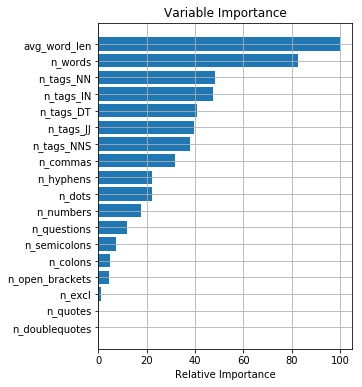

In [98]:
m_i = plot_feat_imp(X_lingv_tr.columns, model.feature_importance(), shir=6)

In [130]:
m_i[:-6]

Index(['avg_word_len', 'n_words', 'n_tags_NN', 'n_tags_IN', 'n_tags_DT',
       'n_tags_JJ', 'n_tags_NNS', 'n_commas', 'n_hyphens', 'n_dots',
       'n_numbers', 'n_questions'],
      dtype='object')

In [14]:
import avlib.feat_stats
reload (avlib.feat_stats)
from avlib.feat_stats import draw_feats

In [139]:
# all_L_x = X_lingv_tr.append(X_lingv_test)
# all_y = y_train.append(y_test)

In [27]:
all_df = X_lingv_tr.merge(pd.DataFrame(y_train, columns=['target']), left_index=True, right_index = True)

In [141]:
all_df.target = all_df['target'].astype(bool)

In [142]:
feats_all = list([m_i[:-5]])[0].to_list()

In [143]:
feats_all

['avg_word_len',
 'n_words',
 'n_tags_NN',
 'n_tags_IN',
 'n_tags_DT',
 'n_tags_JJ',
 'n_tags_NNS',
 'n_commas',
 'n_hyphens',
 'n_dots',
 'n_numbers',
 'n_questions',
 'n_semicolons']

In [33]:
all_df[['avg_word_len', 'n_words']+["target"]]

,avg_word_len,n_words,target
36619,4.875000,32.0,1
37827,5.153846,26.0,1
44099,4.764706,17.0,1
116443,5.580645,31.0,0
85368,5.307692,39.0,0
18788,4.392857,28.0,1
27960,5.000000,30.0,1
59380,4.375000,16.0,1
44472,4.500000,28.0,1
65827,5.153846,13.0,1


(138550, 9)
ginis (9,)
avg_word_len


C:\Users\vaski\sberbank\2kurs\vkr\avlib\feat_stats.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d['bin'] = (dat[x].rank(pct=True, na_option = 'top', method='min') * 20).apply(np.floor)


n_words
n_tags_NN
n_tags_IN
n_tags_DT
n_tags_JJ
n_tags_NNS
n_commas


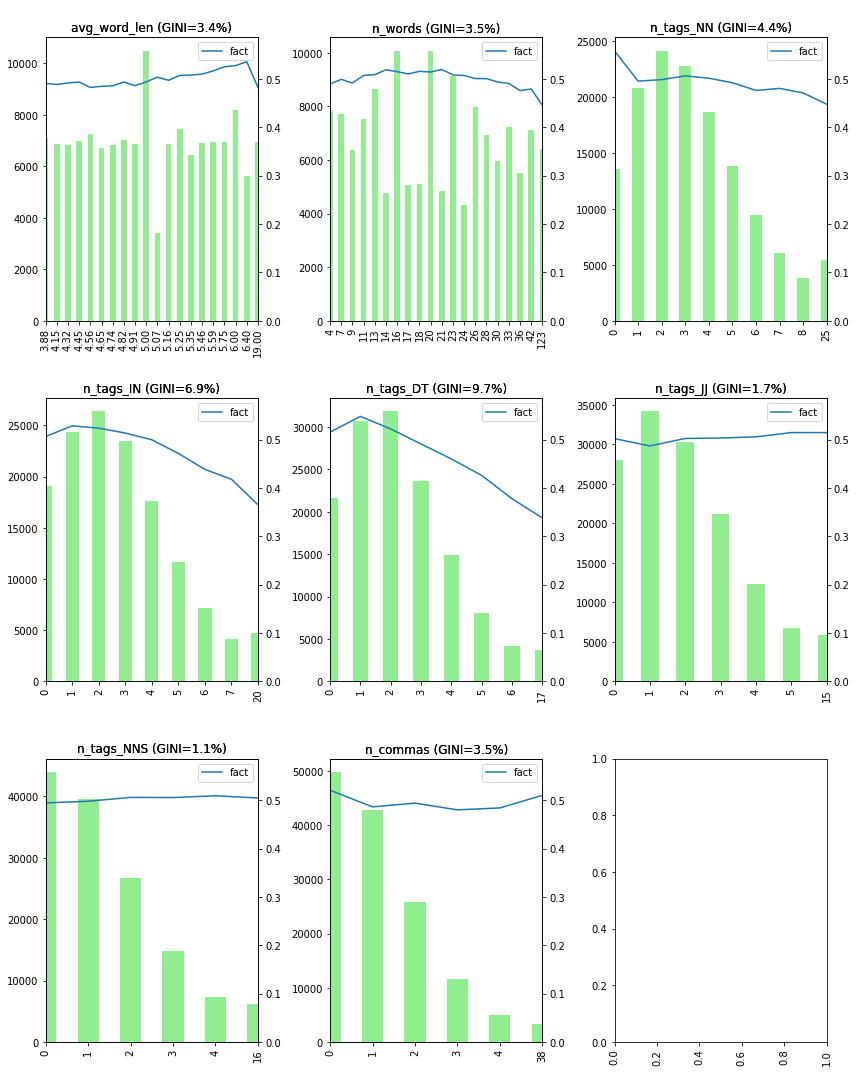

In [42]:
all_df.target = all_df.target.astype('bool')
draw_feats(all_df[['avg_word_len',
 'n_words',
 'n_tags_NN',
 'n_tags_IN',
 'n_tags_DT',
 'n_tags_JJ',
 'n_tags_NNS',
 'n_commas']+["target"]]
#      ,      columns = columns
    , target = 'target' # строка, название поля с таргетом
#     , sort_gini = True # [не обязательно] если True, графики сортируются по gini
#     , figsize = (6, 7) # размер каждой ячейки в дюймах (ширина, высота)
    , ncols=3
    )
# plt.savefig('lingv/vars.png')

(138550, 14)
ginis (14,)
avg_word_len


C:\Users\vaski\sberbank\2kurs\vkr\avlib\feat_stats.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d['bin'] = (dat[x].rank(pct=True, na_option = 'top', method='min') * 20).apply(np.floor)


n_words
n_tags_NN
n_tags_IN
n_tags_DT
n_tags_JJ
n_tags_NNS
n_commas
n_hyphens
n_dots
n_numbers
n_questions
n_semicolons


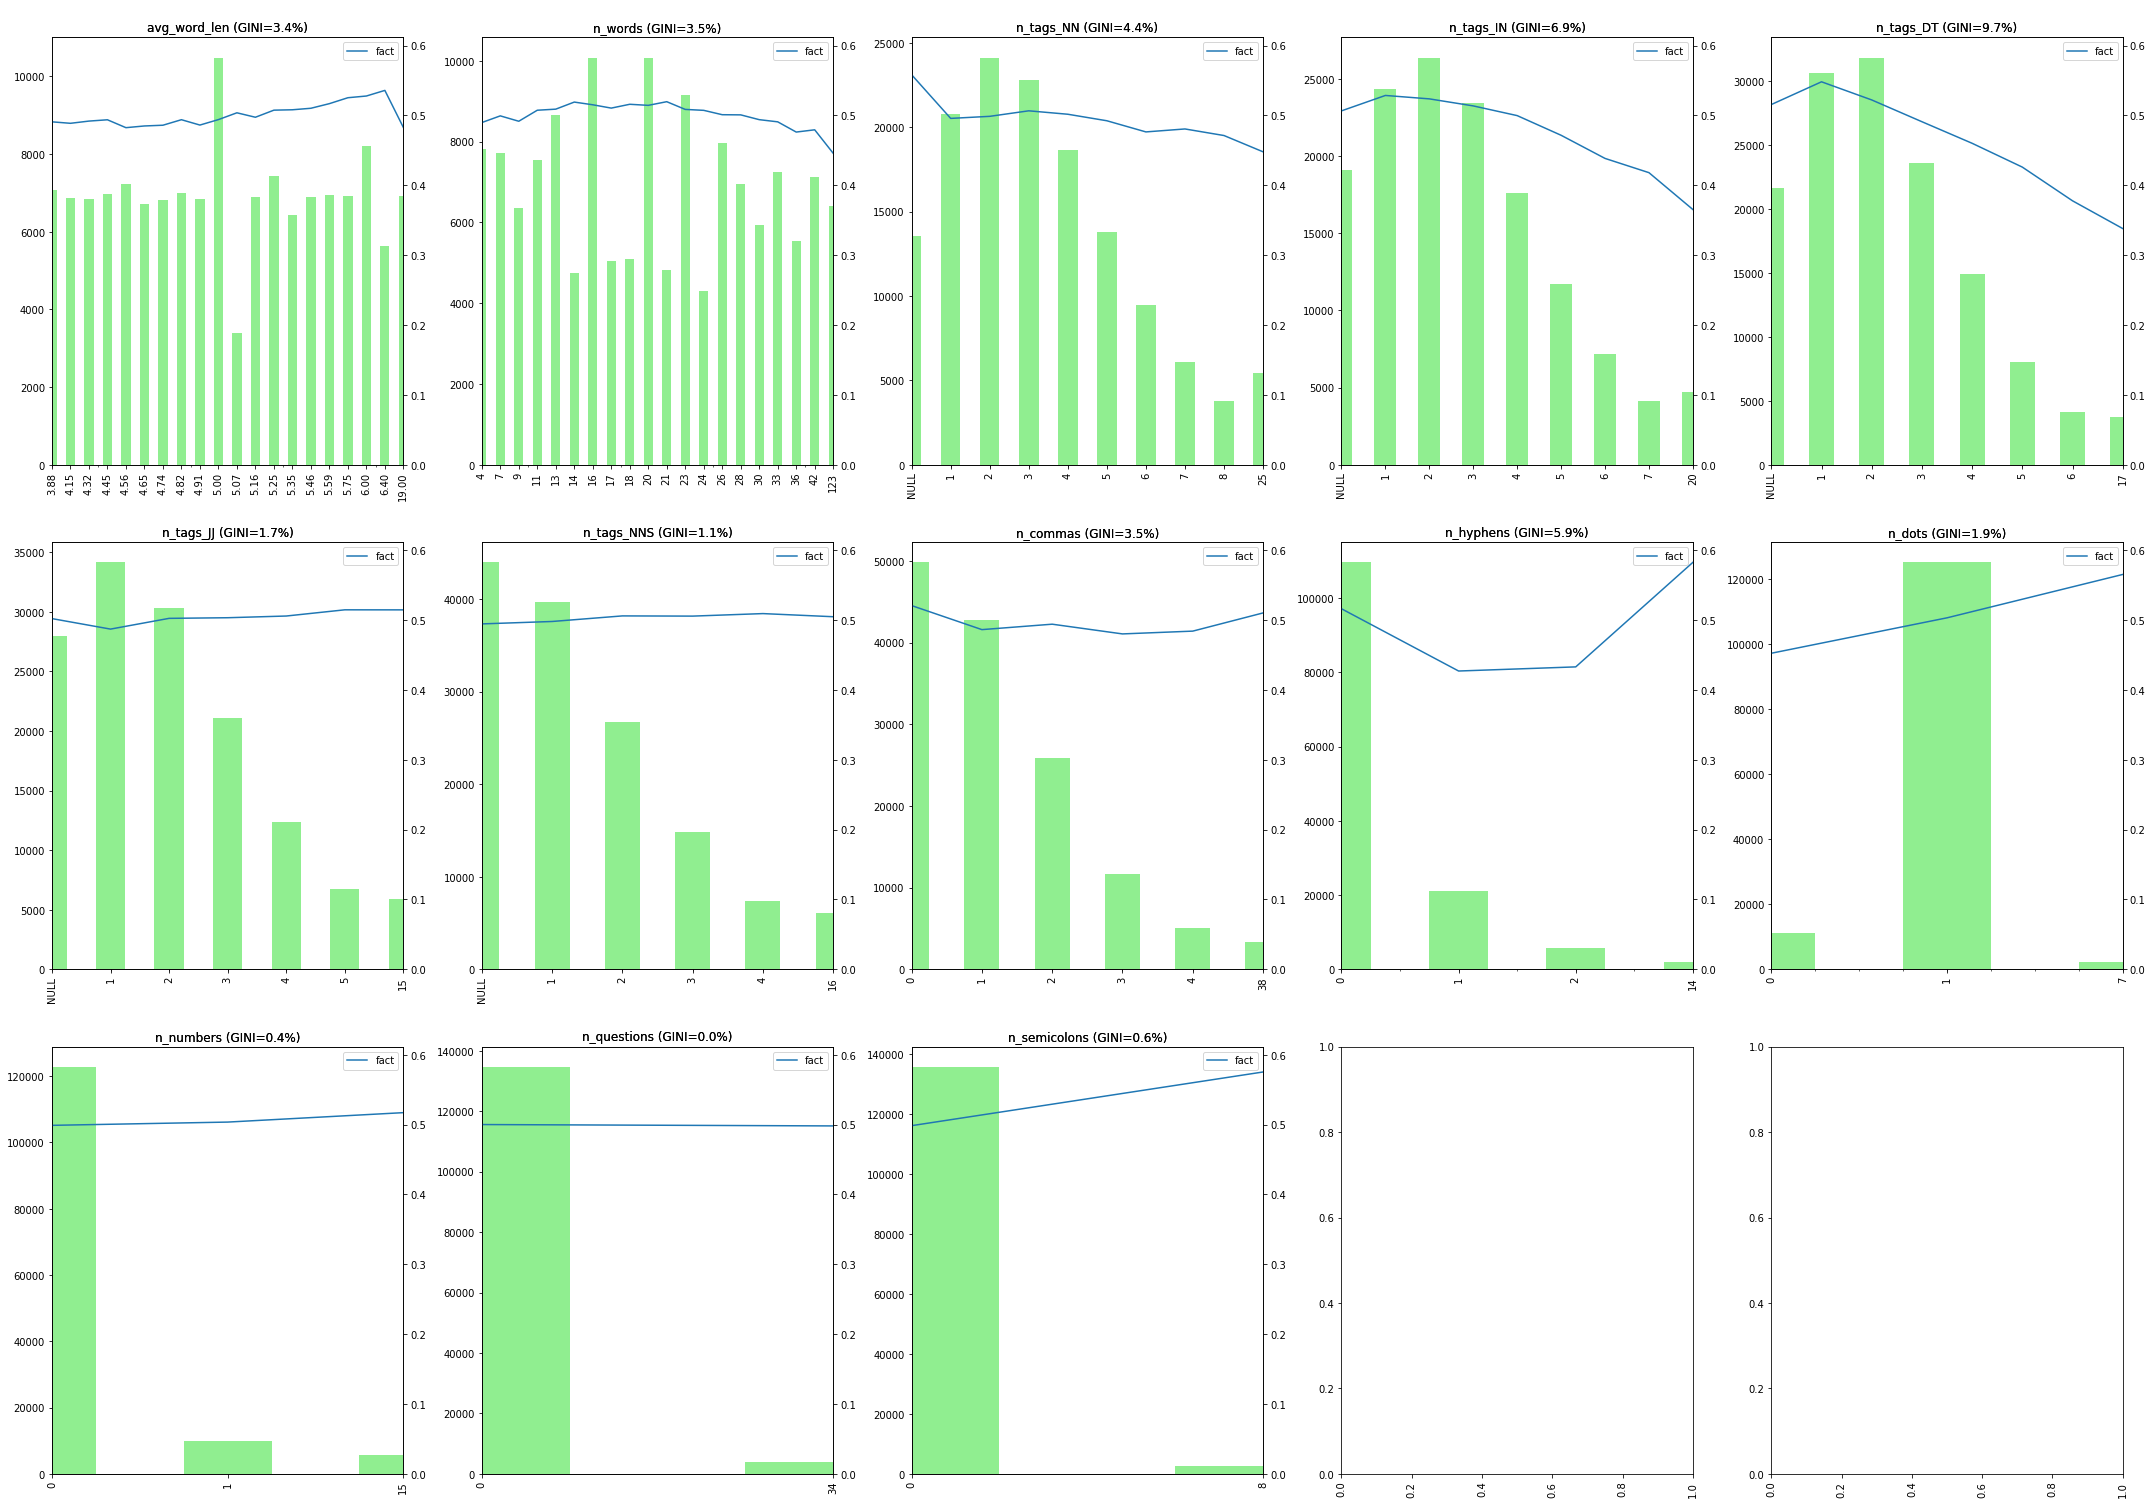

In [153]:
draw_feats(all_df[feats_all+["target"]]
#      ,      columns = columns
    , target = 'target' # строка, название поля с таргетом
#     , sort_gini = True # [не обязательно] если True, графики сортируются по gini
    , figsize = (6, 7) # размер каждой ячейки в дюймах (ширина, высота)
    , ncols=5
    )
# plt.savefig('lingv/vars.png')

In [315]:
joblib.dump(model,'lingv/lgb_model')

['lingv/lgb_model']

In [15]:
import joblib
lingv = joblib.load('lingv/lgb_model')

In [317]:
lingv_preds = model.predict(X_lingv_test)

In [318]:
lingv_lgb_acc = accuracy_score(y_test, lingv_preds>0.5)
lingv_lgb_acc

0.5999769039782897

In [319]:
lingv_lgb_roc = roc_auc_score(y_test, lingv_preds)
lingv_lgb_roc

0.6473079123934518

In [320]:
show_weights(clf_xgb.best_estimator_, feature_names=list(X_lingv_tr.columns))

Weight,Feature
0.1457,n_questions
0.1257,n_tags_DT
0.0992,n_hyphens
0.0809,n_dots
0.0763,n_tags_NN
0.0603,n_tags_NNS
0.0590,n_tags_IN
0.0571,n_words
0.0536,n_numbers
0.0519,n_semicolons


In [321]:
lingv_results = pd.DataFrame(columns=["Embedding", "Model", "Accuracy", "ROC-AUC"], index=np.arange(3))
lingv_results.loc[:2] = "Lingvistic"

lingv_results.iloc[0][1] = "Logistic Regression"
lingv_results.iloc[1][1] = " XGboost"
lingv_results.iloc[2][1] = " LightGBM"
        
lingv_results.iloc[2][2] = round(lingv_lgb_acc,4)
lingv_results.iloc[2][3] = round(lingv_lgb_roc,4)
lingv_results.iloc[1][2] = round(lingv_xgb_acc,4)
lingv_results.iloc[1][3] = round(lingv_xgb_roc,4)
lingv_results.iloc[0][2] = round(lingv_lr_acc,4)
lingv_results.iloc[0][3] = round(lingv_lr_roc,4)
lingv_results

,Embedding,Model,Accuracy,ROC-AUC
0,Lingvistic,Logistic Regression,0.5605,0.5867
1,Lingvistic,XGboost,0.5997,0.6466
2,Lingvistic,LightGBM,0.6,0.6473


In [16]:
lingv_results.style.apply(lambda x: ['background: lightgreen' if x.name in [2]  else '' for i in x], axis=1)

,Embedding,Model,Accuracy,ROC-AUC
0,Lingvistic,Logistic Regression,0.5605,0.5867
1,Lingvistic,XGboost,0.5997,0.6466
2,Lingvistic,LightGBM,0.6,0.6473


In [323]:
lingv_results.to_pickle('lingv/lingv_result')

In [15]:
lingv_results = pd.read_pickle('lingv/lingv_result')

In [324]:
l_res = pd.DataFrame(lingv_results.groupby(['Embedding', 'Model'])['Accuracy', 'ROC-AUC'].min())
l_res

Accuracy  ROC-AUC
Embedding  Model                                 
Lingvistic  LightGBM              0.6000   0.6473
            XGboost               0.5997   0.6466
           Logistic Regression    0.5605   0.5867

In [325]:
l_res.style.apply(lambda x: ['background: lightgreen' if i == 0.6 or i == 0.6473 else '' for i in x], axis=1)

In [336]:
lgb_param = {
                'seed':123,
               'feature_fraction': 0.75,
               'metric': 'auc',
               'nthread':7, 
               'min_data_in_leaf': 2**3, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.0005, 
               'objective': 'binary', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**3,
               'bagging_freq': 5,
               'verbose':20 ,
                'max_depth':1
              }

### Все признаки, включая лингвистические

### FastText

In [45]:
all_train = pd.merge(X_tr_ft, X_lingv_tr, right_index = True, left_index = True)
all_test = pd.merge(X_test_ft, X_lingv_test, right_index = True, left_index = True)

In [46]:
all_train.head()

,0,1,2,3,4,5,6,7,8,9,...,n_open_brackets,n_questions,n_quotes,n_semicolons,n_tags_DT,n_tags_IN,n_tags_JJ,n_tags_NN,n_tags_NNS,n_words
36619,0.149720,0.141460,-0.072833,0.082142,-0.026121,-0.095211,-0.028344,-0.050198,0.061298,-0.094764,...,0.0,0.0,0.0,0.0,3.0,5.0,4.0,9.0,1.0,32.0
37827,0.131900,0.168538,-0.006073,0.126321,-0.000075,-0.035449,-0.053413,-0.064281,0.081270,-0.057280,...,0.0,0.0,0.0,0.0,1.0,2.0,6.0,3.0,2.0,26.0
44099,0.083942,0.118543,-0.076287,0.093491,0.011457,-0.041028,-0.029877,0.021399,0.155497,-0.052221,...,0.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,0.0,17.0
116443,0.138535,0.140776,-0.071289,-0.016056,0.026772,-0.087249,0.018738,-0.108708,0.036084,-0.019022,...,0.0,0.0,0.0,0.0,4.0,1.0,4.0,6.0,0.0,31.0
85368,0.167767,0.127441,-0.048274,0.079005,0.057538,-0.077670,-0.051920,-0.090508,0.054329,-0.007322,...,0.0,0.0,0.0,0.0,5.0,6.0,4.0,3.0,4.0,39.0


In [44]:
lgb_params_to_all = {
                'seed':123,
               'feature_fraction': 0.75,
               'metric': 'auc',
               'nthread':7, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.005, 
               'objective': 'binary', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':3,
               'verbose':20
              }

In [340]:
model = lgb.train(lgb_params_to_all, lgb.Dataset(all_train, label=y_train), valid_sets=lgb.Dataset(all_test,
                                                                                                label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's auc: 0.709643
[1000]	valid_0's auc: 0.723699
[1500]	valid_0's auc: 0.731029
[2000]	valid_0's auc: 0.735679
[2500]	valid_0's auc: 0.738777
[3000]	valid_0's auc: 0.741204
[3500]	valid_0's auc: 0.742832
[4000]	valid_0's auc: 0.744132
[4500]	valid_0's auc: 0.745252
[5000]	valid_0's auc: 0.746163
[5500]	valid_0's auc: 0.746985
[6000]	valid_0's auc: 0.747619
[6500]	valid_0's auc: 0.748173
Early stopping, best iteration is:
[6515]	valid_0's auc: 0.74819


In [341]:
all_ft_acc = accuracy_score(y_test, model.predict(all_test)>0.5)
all_ft_acc

0.6755008949708413

In [342]:
all_ft_roc = roc_auc_score(y_test, model.predict(all_test))
all_ft_roc

0.7481895239084648

In [343]:
joblib.dump(model, 'all_new/all_model_ft')

['all_new/all_model_ft']

### TF-IDF

In [156]:
X_train_tfidf.shape

(138550, 1236)

In [157]:
# X_new_tr_tfidf = X_train_tfidf.tocsr()[:,feats_lr]
all_train = hstack([X_train_tfidf.tocsr(), csr_matrix(X_lingv_tr)]).tocsr()
all_test = hstack([X_test_tfidf.tocsr(), csr_matrix(X_lingv_test)]).tocsr()

In [158]:
all_train.shape

(138550, 1254)

In [159]:
model = lgb.train(lgb_params_to_all, lgb.Dataset(all_train, label=y_train), valid_sets=lgb.Dataset(all_test,
                                                                                                label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's auc: 0.718616
[1000]	valid_0's auc: 0.739945
[1500]	valid_0's auc: 0.749067
[2000]	valid_0's auc: 0.753571
[2500]	valid_0's auc: 0.756072
[3000]	valid_0's auc: 0.757409
[3500]	valid_0's auc: 0.758083
[4000]	valid_0's auc: 0.758612
Early stopping, best iteration is:
[4200]	valid_0's auc: 0.758737


In [160]:
all_tfidf_acc_lgb = accuracy_score(y_test, model.predict(all_test)>0.5)
all_tfidf_acc_lgb

0.6849125238177723

In [161]:
all_tfidf_roc_lgb = roc_auc_score(y_test, model.predict(all_test))
all_tfidf_roc_lgb

0.7587369772031738

In [162]:
joblib.dump(model, 'all_new/all_model_tfidf_lgb2')

['all_new/all_model_tfidf_lgb2']

### Word2Vec

In [357]:
all_train = pd.merge(X_tr_w2v, X_lingv_tr, right_index = True, left_index = True)
all_test = pd.merge(X_test_w2v, X_lingv_test, right_index = True, left_index = True)

In [358]:
all_train.head()

,0,1,2,3,4,5,6,7,8,9,...,n_open_brackets,n_questions,n_quotes,n_semicolons,n_tags_DT,n_tags_IN,n_tags_JJ,n_tags_NN,n_tags_NNS,n_words
36619,0.000044,0.000155,0.000070,0.000017,0.000160,-0.000024,3.241924e-07,0.000133,-0.000072,-0.000170,...,0.0,0.0,0.0,0.0,3.0,5.0,4.0,9.0,1.0,32.0
37827,0.000039,0.000100,0.000007,0.000051,0.000213,0.000256,6.714407e-05,-0.000034,-0.000157,0.000057,...,0.0,0.0,0.0,0.0,1.0,2.0,6.0,3.0,2.0,26.0
44099,-0.000293,0.000020,0.000078,0.000044,0.000150,0.000219,1.210975e-04,-0.000092,-0.000160,-0.000047,...,0.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,0.0,17.0
116443,0.000143,-0.000048,-0.000007,-0.000158,0.000094,0.000243,4.269032e-05,0.000022,-0.000064,-0.000056,...,0.0,0.0,0.0,0.0,4.0,1.0,4.0,6.0,0.0,31.0
85368,-0.000059,-0.000173,0.000035,0.000013,0.000160,0.000066,1.981127e-05,0.000033,-0.000204,-0.000119,...,0.0,0.0,0.0,0.0,5.0,6.0,4.0,3.0,4.0,39.0


In [359]:
model = lgb.train(lgb_params_to_all, lgb.Dataset(all_train, label=y_train), valid_sets=lgb.Dataset(all_test,
                                                                                                label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 500)

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's auc: 0.687038
[1000]	valid_0's auc: 0.702785
[1500]	valid_0's auc: 0.711055
[2000]	valid_0's auc: 0.716459
[2500]	valid_0's auc: 0.719629
[3000]	valid_0's auc: 0.722138
[3500]	valid_0's auc: 0.724015
[4000]	valid_0's auc: 0.725573
[4500]	valid_0's auc: 0.726774
[5000]	valid_0's auc: 0.727922
[5500]	valid_0's auc: 0.728827
[6000]	valid_0's auc: 0.729651
[6500]	valid_0's auc: 0.730388
[7000]	valid_0's auc: 0.730852
[7500]	valid_0's auc: 0.731338
[8000]	valid_0's auc: 0.731699
Early stopping, best iteration is:
[7995]	valid_0's auc: 0.731708


In [360]:
all_w2v_acc = accuracy_score(y_test, model.predict(all_test)>0.5)
all_w2v_acc

0.6643859345227785

In [361]:
all_w2v_roc = roc_auc_score(y_test, model.predict(all_test))
all_w2v_roc

0.7317076222482621

In [362]:
joblib.dump(model, 'all_new/all_model_w2v')

['all_new/all_model_w2v']

### Doc2Vec

In [363]:
all_train = pd.merge(X_tr_d2v, X_lingv_tr, right_index = True, left_index = True)
all_test = pd.merge(X_test_d2v, X_lingv_test, right_index = True, left_index = True)

In [364]:
all_train.head()

,0,1,2,3,4,5,6,7,8,9,...,n_open_brackets,n_questions,n_quotes,n_semicolons,n_tags_DT,n_tags_IN,n_tags_JJ,n_tags_NN,n_tags_NNS,n_words
36619,0.110588,0.426981,0.094492,-0.079861,-0.093539,-0.248971,-0.075165,0.273293,-0.424543,-0.226707,...,0.0,0.0,0.0,0.0,3.0,5.0,4.0,9.0,1.0,32.0
37827,0.085754,0.187763,0.036846,-0.215144,-0.012402,-0.089977,-0.297900,0.107784,-0.459050,-0.017884,...,0.0,0.0,0.0,0.0,1.0,2.0,6.0,3.0,2.0,26.0
44099,0.208997,0.530453,-0.101463,-0.373936,-0.017022,-0.186407,-0.042033,-0.134491,-0.371968,-0.060676,...,0.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,0.0,17.0
116443,0.391163,0.303057,-0.059777,-0.175164,-0.006675,-0.135500,-0.000036,0.061582,-0.494438,-0.076032,...,0.0,0.0,0.0,0.0,4.0,1.0,4.0,6.0,0.0,31.0
85368,0.161263,0.294343,-0.138503,-0.380779,-0.155975,0.078906,-0.364763,0.070855,-0.589957,0.021906,...,0.0,0.0,0.0,0.0,5.0,6.0,4.0,3.0,4.0,39.0


In [366]:
model = lgb.train(lgb_params_to_all, lgb.Dataset(all_train, label=y_train), valid_sets=lgb.Dataset(all_test,
                                                                                                label=y_test),
                  early_stopping_rounds=50, num_boost_round=10000, verbose_eval = 250)

Training until validation scores don't improve for 50 rounds.
[250]	valid_0's auc: 0.698667
[500]	valid_0's auc: 0.711788
[750]	valid_0's auc: 0.71933
[1000]	valid_0's auc: 0.724321
[1250]	valid_0's auc: 0.727556
[1500]	valid_0's auc: 0.729929
[1750]	valid_0's auc: 0.731574
[2000]	valid_0's auc: 0.733052
[2250]	valid_0's auc: 0.734314
[2500]	valid_0's auc: 0.734975
[2750]	valid_0's auc: 0.735737
[3000]	valid_0's auc: 0.736343
[3250]	valid_0's auc: 0.736971
[3500]	valid_0's auc: 0.737384
[3750]	valid_0's auc: 0.737911
[4000]	valid_0's auc: 0.73827
[4250]	valid_0's auc: 0.738543
[4500]	valid_0's auc: 0.738884
[4750]	valid_0's auc: 0.739111
[5000]	valid_0's auc: 0.739351
[5250]	valid_0's auc: 0.739624
Early stopping, best iteration is:
[5403]	valid_0's auc: 0.739713


In [367]:
all_d2v_acc = accuracy_score(y_test, model.predict(all_test)>0.5)
all_d2v_acc

0.6727005023384722

In [368]:
all_d2v_roc = roc_auc_score(y_test, model.predict(all_test))
all_d2v_roc

0.7397131179118888

In [369]:
joblib.dump(model, 'all_new/all_model_d2v')

['all_new/all_model_d2v']

In [171]:
all_tfidf_roc_lgb

0.7587369772031738

In [175]:
all_results = pd.DataFrame(columns=["Embedding", "Model", "Accuracy", "ROC-AUC"], index=np.arange(5))
all_results.loc[0][0] = "FastText"
all_results.loc[1][0] = "TF-IDF"
all_results.loc[2][0] = "Word2Vec"
all_results.loc[3][0] = "Doc2Vec"
all_results.iloc[:,1] = "LightGBM"
        
all_results.iloc[1][2] = round(all_tfidf_acc_lgb,4)
all_results.iloc[1][3] = round(all_tfidf_roc_lgb,4)
all_results.iloc[0][2] = round(all_ft_acc,4)
all_results.iloc[0][3] = round(all_ft_roc,4)

all_results.iloc[2][2] = round(all_w2v_acc,4)
all_results.iloc[2][3] = round(all_w2v_roc,4)
all_results.iloc[3][2] = round(all_d2v_acc,4)
all_results.iloc[3][3] = round(all_d2v_roc,4)
all_results

,Embedding,Model,Accuracy,ROC-AUC
0,FastText,LightGBM,0.6755,0.7482
1,TF-IDF,LightGBM,0.6849,0.7587
3,Word2Vec,LightGBM,0.6644,0.7317
4,Doc2Vec,LightGBM,0.6727,0.7397


In [176]:
all_results.style.apply(lambda x: ['background: lightgreen' if x.name in [1]  else '' for i in x], axis=1)

,Embedding,Model,Accuracy,ROC-AUC
0,FastText,LightGBM,0.6755,0.7482
1,TF-IDF,LightGBM,0.6849,0.7587
3,Word2Vec,LightGBM,0.6644,0.7317
4,Doc2Vec,LightGBM,0.6727,0.7397


In [166]:
all_results = pd.read_pickle('all_new/all_result2')

In [177]:
all_results.to_pickle('all_new/all_resul1t2')

In [178]:
all_res = pd.DataFrame(all_results.groupby(['Embedding', 'Model'])['Accuracy', 'ROC-AUC'].min())
all_res

,,Accuracy,ROC-AUC
Embedding,Model,,
Doc2Vec,LightGBM,0.6727,0.7397
FastText,LightGBM,0.6755,0.7482
TF-IDF,LightGBM,0.6849,0.7587
Word2Vec,LightGBM,0.6644,0.7317


In [179]:
all_res.style.apply(lambda x: ['background: lightgreen' if i == 0.7068 or i == 0.7836 else '' for i in x], axis=1)

,,Accuracy,ROC-AUC
Embedding,Model,,
Doc2Vec,LightGBM,0.6727,0.7397
FastText,LightGBM,0.6755,0.7482
TF-IDF,LightGBM,0.6849,0.7587
Word2Vec,LightGBM,0.6644,0.7317


## Исследование данных

Так как все предложения разной длины, но необходима одна длина, обрежем все предложения по некоторому количеству. Чтобы определить это количество, посмотрим на распределение количества частей предложения.

In [42]:
def sent_part_tokenize(sent):
    tok = []
    cur = []
    for word in np.array(word_tokenize(sent)):
        if word not in [',', ';']:
            if word not in ['.', '?', '!']:
                cur.append(word.lower())
        else:
            tok.append(cur)
            cur = []
    tok.append(cur)
    return tok

In [43]:
sent_lens = np.array([len(sent_part_tokenize(sent)) for sent in\
                     list(train_data['english']) + list(train_data['translated'])])

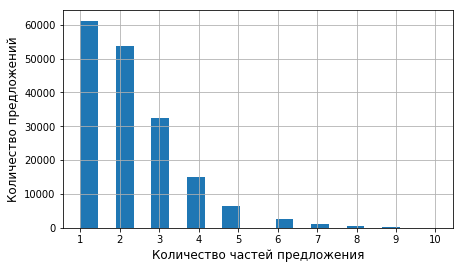

In [111]:
plt.figure(figsize=(7, 4))
plt.hist(sent_lens[sent_lens < 11], bins=20)
plt.locator_params(nbins=10, axis='x')
plt.grid()
plt.xlabel('Количество предложения', size=12)
plt.ylabel('Количество текстов', size=12)
plt.savefig('sent_lens_dist.png')

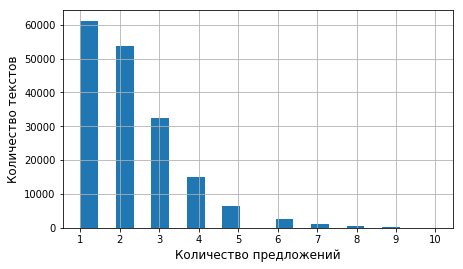

In [45]:
plt.figure(figsize=(7, 4))
plt.hist(sent_lens[sent_lens < 11], bins=20)
plt.locator_params(nbins=10, axis='x')
plt.grid()
plt.xlabel('Количество предложений', size=12)
plt.ylabel('Количество текстов', size=12)
plt.savefig('sent_lens_dist.png')

Видим, что почти все предложения содержат меньше 10 частей, поэтому ограничимся этим числом.

Теперь аналогично посмотрим на распределение количества слов в частях предложений.

In [112]:
part_sent_lens = np.array([len(part_sent) for sent in\
                           list(train_data['english']) + list(train_data['translated'])\
                           for part_sent in sent_part_tokenize(sent)])

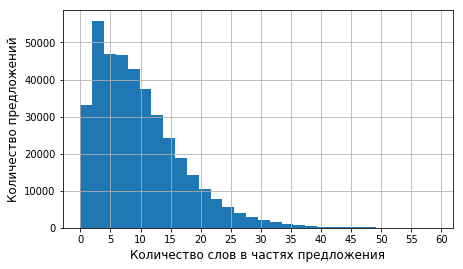

In [113]:
plt.figure(figsize=(7, 4))
plt.hist(part_sent_lens[part_sent_lens < 60], bins=30)
plt.locator_params(nbins=20, axis='x')
plt.xlabel('Количество слов в частях предложения', size=12)
plt.ylabel('Количество предложений', size=12)
plt.grid()
plt.savefig('part_sent_lens_dist.png')

Почти все предложения содержат меньше 50 слов.

In [114]:
sent_lens = np.array([len(word_tokenize(sent)) for sent in\
                           list(train_data['english']) + list(train_data['translated'])])

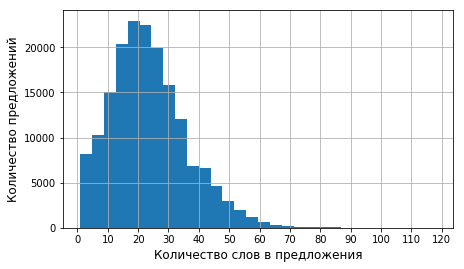

In [115]:
plt.figure(figsize=(7, 4))
plt.hist(sent_lens[sent_lens < 120], bins=30)
plt.locator_params(nbins=20, axis='x')
plt.xlabel('Количество слов в предложения', size=12)
plt.ylabel('Количество предложений', size=12)
plt.grid()
plt.savefig('word_sent_lens_dist.png')

### HAN

Разделим предложения на части по запятым, и на слова

In [21]:
sent = train_data.loc[8100, 'translated']
print(sent)
print(sent_part_tokenize(sent))

The procedure for the impeachment of President Clinton in the US Senate and a political crisis that could strengthen both political and economic instability , and thus resulted in another sharp fall in prices on Wall Street , it seems has not had any effect on the Americans and on how they spend or keep their money .
[['the', 'procedure', 'for', 'the', 'impeachment', 'of', 'president', 'clinton', 'in', 'the', 'us', 'senate', 'and', 'a', 'political', 'crisis', 'that', 'could', 'strengthen', 'both', 'political', 'and', 'economic', 'instability'], ['and', 'thus', 'resulted', 'in', 'another', 'sharp', 'fall', 'in', 'prices', 'on', 'wall', 'street'], ['it', 'seems', 'has', 'not', 'had', 'any', 'effect', 'on', 'the', 'americans', 'and', 'on', 'how', 'they', 'spend', 'or', 'keep', 'their', 'money']]


In [22]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=500000)

In [23]:
class Simple_model:
    def __init__(self):
        print('Loading word2vec model...')
#         self.w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
        self.w2v_model = w2v_model
        self.max_words = 90
        self.vocab_dim = 300
    
    def embed(self, docs, train=True):
        if train:
            self.tokenizer = Tokenizer()
            self.tokenizer.fit_on_texts([' '.join(sent) for sent in docs])
        
        self.index_dict = {}
        embedings = np.zeros((len(docs), self.max_words), dtype='int64')
        for i, doc in enumerate(docs):
            doc_embedings = []
            k = 0
            for word in doc:
                if k < self.max_words:
                    if word in self.tokenizer.word_index:
                        embedings[i, k] = self.tokenizer.word_index[word]
                        self.index_dict[word] = embedings[i, k]
                        k += 1
                else:
                    break
#             print('Progress: {}/{}'.format(i + 1, len(docs)), end='\r')
        print()
        print('Embeddings shape: {}'.format(embedings.shape))
        print('Unique words: {}'.format(len(self.index_dict)))
        print('Maximum words in a sentence: {}'.format(self.max_words))
        
        self.word_vectors = {}
        for word, index in self.index_dict.items():
            try:
                self.word_vectors[word] = self.w2v_model[word]
            except:
                pass
        
        return embedings
    
    def transform_data(self, data, train=True):
        print('Total: {} documents\n'.format(len(data)))
        print('Clearing and tokenizing data...')
        data_tok = []
        for i, doc in enumerate(data):
#             print('Progress: {}/{}'.format(i + 1, len(data)), end='\r')
            data_tok.append(word_tokenize(doc))
        print('\n')
        
        print('Getting embeddings...')
        embedings = self.embed(data_tok, train=train)
        print()
        
        return embedings

In [24]:
model = Simple_model()

Loading word2vec model...


In [25]:
embedings = model.transform_data(X_train['english'])

Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90



In [26]:
# emb_tr = embedings
# emb_test = model.transform_data(X_test['english'], train=False)

In [27]:
def dot_product(x, kernel):
    return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)

class Attention(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('glorot_uniform')
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name))
        self.b = self.add_weight((input_shape[-1],),
                                 initializer='zero',
                                 name='{}_b'.format(self.name))
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name))

        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        uit = K.tanh(dot_product(x, self.W) + self.b)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [28]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

In [29]:
# assemble the embedding_weights in one numpy array
n_symbols = max(model.index_dict.values()) + 1 # adding 1 to account for 0th index (for masking)
embedding_weights = np.zeros((n_symbols, model.vocab_dim))
for word, index in model.index_dict.items():
    emb_vector = model.word_vectors.get(word)
    if emb_vector is not None:
        embedding_weights[index, :] = emb_vector

# define inputs here
embedding_layer = Embedding(output_dim=model.vocab_dim, input_dim=n_symbols, trainable=True)
embedding_layer.build((None,)) # if you don't do this, the next step won't work
embedding_layer.set_weights([embedding_weights])

In [30]:
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense

In [26]:
sentence_input = Input(shape=(model.max_words,))
embedded_sequences = embedding_layer(sentence_input)
gru = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
att = Attention()(gru)

# bn = BatchNormalization()(att)
# dn = Dense(50, activation='relu')(att)
dr = (Dropout(0.2))(att)

preds = Dense(1, activation='sigmoid')(dr)
HANmodel = Model(sentence_input, preds)

In [27]:
HANmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [28]:
HANmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 90, 300)           12769200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 90, 200)           240600    
_________________________________________________________________
attention_1 (Attention)      (None, 200)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 13,050,401
Trainable params: 13,050,401
Non-trainable params: 0
________________________________________________________________

In [29]:
bt = TFLogger('data/graph',64, STEP_SIZE_TRAIN=len(y_train)//64)

In [30]:
checkpoint = ModelCheckpoint('data/checkpoints/han-{epoch:02d}-{val_loss:.3f}.hdf5', save_best_only=True)
tbCallBack = TensorBoard(log_dir='data/graph', histogram_freq=10, write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.0001, 
                           cooldown=0, min_lr=0.0001)
tqdmn = TQDMNotebookCallback(leave_inner=True)

In [89]:
HANmodel.fit(embedings, y_train, validation_split=0.1, epochs=10, batch_size=64,
             callbacks=[red_lr, early_stop, checkpoint], verbose=2)

Train on 124695 samples, validate on 13855 samples
Epoch 1/10
 - 1384s - loss: 0.6591 - acc: 0.6092 - val_loss: 0.6491 - val_acc: 0.6149
Epoch 2/10
 - 1364s - loss: 0.6332 - acc: 0.6412 - val_loss: 0.6422 - val_acc: 0.6251
Epoch 3/10
 - 1366s - loss: 0.6220 - acc: 0.6525 - val_loss: 0.6464 - val_acc: 0.6216

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/10
 - 1368s - loss: 0.5941 - acc: 0.6761 - val_loss: 0.6705 - val_acc: 0.6156

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 5/10
 - 1377s - loss: 0.5701 - acc: 0.6948 - val_loss: 0.6487 - val_acc: 0.6310

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


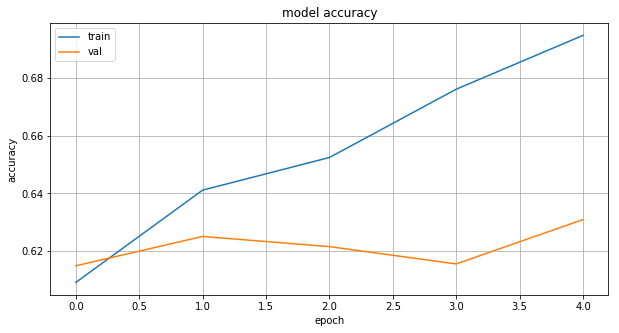

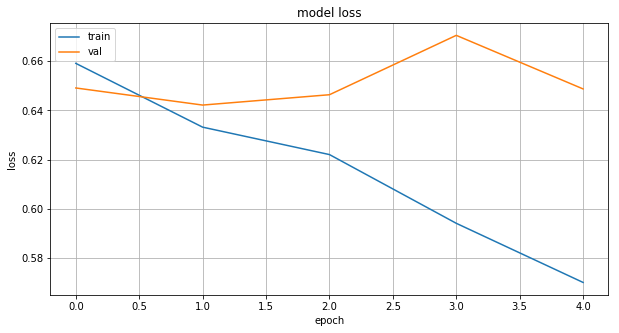

In [90]:
plot_history(HANmodel.history)

#### GRU model

In [180]:
model = Simple_model()

Loading word2vec model...


In [181]:
embedings = model.transform_data(X_train['english'])

Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90



In [67]:
# assemble the embedding_weights in one numpy array
n_symbols = max(model.index_dict.values()) + 1 # adding 1 to account for 0th index (for masking)
embedding_weights = np.zeros((n_symbols, model.vocab_dim))
for word, index in model.index_dict.items():
    emb_vector = model.word_vectors.get(word)
    if emb_vector is not None:
        embedding_weights[index, :] = emb_vector

# define inputs here
embedding_layer = Embedding(output_dim=model.vocab_dim, input_dim=n_symbols, trainable=True)
embedding_layer.build((None,)) # if you don't do this, the next step won't work
embedding_layer.set_weights([embedding_weights])

In [68]:
import bat_logger
from bat_logger import TFLogger
bt = TFLogger('data/graph_gru',64, STEP_SIZE_TRAIN=len(y_train)//64, log_every=500)

In [69]:
checkpoint = ModelCheckpoint('data/checkpoints/gru-{epoch:02d}-{val_loss:.3f}.hdf5', save_best_only=True)
tbCallBack = TensorBoard(log_dir='data/graph_gru', write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.0001, 
                           cooldown=0, min_lr=0.0001)
tqdmn = TQDMNotebookCallback(leave_inner=True)

In [70]:
sentence_input = Input(shape=(model.max_words,))
embedded_sequences = embedding_layer(sentence_input)
gru = Bidirectional(GRU(100))(embedded_sequences)

dr = (Dropout(0.2))(gru)

preds = Dense(1, activation='sigmoid')(dr)
# preds = Dense(1, activation='sigmoid')(gru)
GRUmodel = Model(sentence_input, preds)

In [71]:
GRUmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [72]:
GRUmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 90)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 90, 300)           12769200  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               240600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 13,010,001
Trainable params: 13,010,001
Non-trainable params: 0
_________________________________________________________________


In [73]:
GRUmodel.fit(embedings, y_train, validation_split=0.1, epochs=10, batch_size=64,
             callbacks=[red_lr, early_stop, checkpoint], verbose=2)

Train on 124695 samples, validate on 13855 samples
Epoch 1/10
 - 1209s - loss: 0.6776 - acc: 0.5906 - val_loss: 0.6796 - val_acc: 0.5840
Epoch 2/10
 - 1200s - loss: 0.6674 - acc: 0.6063 - val_loss: 0.6659 - val_acc: 0.5933
Epoch 3/10
 - 1196s - loss: 0.6655 - acc: 0.6096 - val_loss: 0.6740 - val_acc: 0.6000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/10
 - 1200s - loss: 0.6372 - acc: 0.6347 - val_loss: 0.6535 - val_acc: 0.6145
Epoch 5/10
 - 1197s - loss: 0.6248 - acc: 0.6476 - val_loss: 0.6651 - val_acc: 0.6047

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 6/10
 - 1200s - loss: 0.6069 - acc: 0.6640 - val_loss: 0.6499 - val_acc: 0.6212
Epoch 7/10
 - 1200s - loss: 0.5937 - acc: 0.6781 - val_loss: 0.6546 - val_acc: 0.6191

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 8/10
 - 1214s - loss: 0.5757 - acc: 0.6927 - val_loss: 0.6592 - val_acc: 0.6160

Epoch 00008: Reduc

### LSTM

In [46]:
# assemble the embedding_weights in one numpy array
n_symbols = max(model.index_dict.values()) + 1 # adding 1 to account for 0th index (for masking)
embedding_weights = np.zeros((n_symbols, model.vocab_dim))
for word, index in model.index_dict.items():
    emb_vector = model.word_vectors.get(word)
    if emb_vector is not None:
        embedding_weights[index, :] = emb_vector

# define inputs here
embedding_layer = Embedding(output_dim=model.vocab_dim, input_dim=n_symbols, trainable=True)
embedding_layer.build((None,)) # if you don't do this, the next step won't work
embedding_layer.set_weights([embedding_weights])

In [30]:
bt = TFLogger('data/graph_lstm',64, STEP_SIZE_TRAIN=len(y_train)//64, log_every=50)

In [47]:
checkpoint = ModelCheckpoint('data/checkpoints/lstm-{epoch:02d}-{val_loss:.3f}.hdf5', save_best_only=True)
tbCallBack = TensorBoard(log_dir='data/graph_lstm', write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.0001, 
                           cooldown=0, min_lr=0.0001)
tqdmn = TQDMNotebookCallback(leave_inner=True)

In [65]:
sentence_input = Input(shape=(model.max_words,))
embedded_sequences = embedding_layer(sentence_input)
lstm = LSTM(20, return_sequences=True)(embedded_sequences)
gru = Bidirectional(GRU(100))(lstm)
bn = BatchNormalization()(gru)
dn = Dense(50, activation='relu')(bn)
dr = (Dropout(0.8))(dn)
preds = Dense(1, activation='sigmoid')(dr)
LSTMmodel = Model(sentence_input, preds)

In [66]:
LSTMmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

In [67]:
LSTMmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 90)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 90, 300)           12769200  
_________________________________________________________________
lstm_6 (LSTM)                (None, 90, 20)            25680     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               72600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
__________

In [27]:
LSTMmodel.fit(embedings, y_train, validation_split=0.1, epochs=10, batch_size=64,
             callbacks=[tbCallBack,red_lr, early_stop, checkpoint, bt, tqdmn], verbose=2)

Train on 124695 samples, validate on 13855 samples


Epoch 1/10


 - 747s - loss: 0.6580 - acc: 0.6017 - val_loss: 0.6138 - val_acc: 0.6450
Epoch 2/10


 - 872s - loss: 0.6149 - acc: 0.6591 - val_loss: 0.6111 - val_acc: 0.6527
Epoch 3/10


 - 806s - loss: 0.5840 - acc: 0.6871 - val_loss: 0.6890 - val_acc: 0.6352

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0034999999217689036.
Epoch 4/10


 - 705s - loss: 0.5638 - acc: 0.7023 - val_loss: 0.6471 - val_acc: 0.6351

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024499999126419425.
Epoch 5/10


 - 765s - loss: 0.5417 - acc: 0.7155 - val_loss: 0.6695 - val_acc: 0.6302

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0017150000203400848.



### Results

In [118]:
def neural_res(mod_path, X_test, title):
    if title == 'HAN' or title == 'GRU' or title == 'LSTM':
        X_test = X_test.apply(repl)
        if title == 'HAN':
            HANmodel = load_model(mod_path, custom_objects={'Attention': Attention})
        else:
            HANmodel = load_model(mod_path)
        embedings_test = model.transform_data(X_test, train=False)
        preds1_test = HANmodel.predict(embedings_test)
        
        preds1_test = preds1_test[:,0]
        
    res = roc_auc_score(y_test, preds1_test)
    print('\n', title, ':\nROC-AUC: %f' % (res))

In [119]:
neural_res('data/checkpoints/gru-06-0.650.hdf5', X_test['english'], title = 'GRU')

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 GRU :
ROC-AUC: 0.711737


In [120]:
neural_res('data/checkpoints/lstm-02-0.611.hdf5', X_test['english'], title = 'LSTM')

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 LSTM :
ROC-AUC: 0.747915


In [121]:
neural_res('data/checkpoints/han-06-0.633.hdf5', X_test['english'], title = 'HAN')

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 HAN :
ROC-AUC: 0.726279


### Mixed

In [66]:
X_train.head()

,english
36619,The EU s role in fostering productivity gains ...
37827,Once investors see that Brazil s fiscal policy...
44099,"Of course , not everyone in Europe can be expe..."
116443,Their silence on Iraq reflected their hunch un...
85368,"This is all the more regrettable now , because..."


In [47]:
def mod(mod_path, X_tr, X_test, title):
    if title == 'HAN' or title == 'GRU' or title == 'LSTM':
        X_tr = X_tr.apply(repl)
        X_test = X_test.apply(repl)
        model = Simple_model()
        embedings_tr = model.transform_data(X_tr)
        if title == 'HAN':
            HANmodel = load_model(mod_path, custom_objects={'Attention': Attention})
        else:
            HANmodel = load_model(mod_path)
        preds1 = HANmodel.predict(embedings_tr)
        embedings_test = model.transform_data(X_test, train=False)
        preds1_test = HANmodel.predict(embedings_test)#model.transform_data(X_test, train=False))
    else:
        w2v_mod = joblib.load(mod_path)
        preds1 = w2v_mod.predict(X_tr)
        preds1_test = w2v_mod.predict(X_test)
        
    preds2 = lingv.predict(X_lingv_tr)
    preds2_test = lingv.predict(X_lingv_test)
    
    if title == 'HAN' or title == 'GRU' or title == 'LSTM':
        preds1 = preds1[:,0]
        preds1_test = preds1_test[:,0]
        
    alphas_to_try = np.linspace(0, 1, 1001)
    mist_tr = []

    for alpha in alphas_to_try:
        mix = alpha * preds1 + (1-alpha) *  preds2
        mist_tr.append(roc_auc_score(y_train, mix))
    
    best_alpha = alphas_to_try[np.argmax(mist_tr)]
    r2_train_simple_mix = np.max(mist_tr)
    res = roc_auc_score(y_test, best_alpha * preds1_test + (1-best_alpha) *  preds2_test)
    print('\n', title, ':\nBest alpha: %f' % (best_alpha))
    print('\n', res)
    return best_alpha, res

In [76]:
mod('data/checkpoints/gru-06-0.650.hdf5', X_train['english'], X_test['english'], title = 'GRU')

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 GRU :
Best alpha: 0.511000

 0.7359185221589302


(0.511, 0.7359185221589302)

In [164]:
mod('data/checkpoints/lstm-02-0.611.hdf5', X_train['english'], X_test['english'], title = 'LSTM')

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 LSTM :
Best alpha: 0.599000

 0.7634689328452764


In [183]:
mod('non_lingv/tfidf_lgb_non_lingv3', X_train_tfidf, X_test_tfidf, title = 'TF-IDF')


 TF-IDF :
Best alpha: 0.578000

 0.7466473337002173


(0.578, 0.7466473337002173)

In [160]:
mod('data/checkpoints/han-06-0.633.hdf5', X_train['english'], X_test['english'], title = 'HAN')

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 HAN :
Best alpha: 0.558000

 0.7472523657211096


In [146]:
mod('data/checkpoints/lstm-02-0.611.hdf5', X_train['english'], X_test['english'], title = 'LSTM')
mod('data/checkpoints/han-06-0.633.hdf5', X_train['english'], X_test['english'], title = 'HAN')
mod('data/checkpoints/gru-06-0.650.hdf5', X_train['english'], X_test['english'], title = 'GRU')
mod('non_lingv/ft_500_non_lingv_lgb', X_tr_ft, X_test_ft, title = 'FastText')
mod('non_lingv/tfidf_lgb_non_lingv2', X_train_tfidf, X_test_tfidf, title = 'TF-IDF')
mod('non_lingv/w2v_500_non_lingv', X_tr_w2v, X_test_w2v, title = 'Word2Vec')
mod('non_lingv/d2v_400_non_lingv_lgb', X_tr_d2v, X_test_d2v, title = 'Doc2Vec')

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 HAN :
Best alpha: 0.558000

 0.7472523657211096

 FastText :
Best alpha: 0.938000

 0.722024757837749

 TF-IDF :
Best alpha: 0.217000

 0.7390141111938487

 Word2Vec :
Best alpha: 1.000000

 0.7183949157733502

 Doc2Vec :
Best alpha: 0.922000

 0.7139144105829814


***Второй инпут***

In [240]:
sentence_input = Input(shape=(model.max_words,))
inp2 = Input(shape=(18,))
embedded_sequences = embedding_layer(sentence_input)
gru = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
att = Attention()(gru)

dr = (Dropout(0.8))(att)
concat_layer = Concatenate()([dr, inp2])

preds = Dense(1, activation='sigmoid')(concat_layer)
HANmodel = Model([sentence_input, inp2], preds)

In [241]:
HANmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [242]:
HANmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 90)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 90, 300)      12769200    input_31[0][0]                   
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 90, 200)      240600      embedding_10[1][0]               
__________________________________________________________________________________________________
attention_3 (Attention)         (None, 200)          40400       bidirectional_19[0][0]           
__________________________________________________________________________________________________
dropout_14

In [243]:
bt = TFLogger('data/graph',64, STEP_SIZE_TRAIN=len(y_train)//64, log_every=5000)
checkpoint = ModelCheckpoint('data/checkpoints/han_lingv-{epoch:02d}-{val_loss:.3f}.hdf5', save_best_only=True)
tbCallBack = TensorBoard(log_dir='data/graph', histogram_freq=1, write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.0001, 
                           cooldown=0, min_lr=0.0001)
tqdmn = TQDMNotebookCallback(leave_inner=True)

In [244]:
model = Simple_model()
embedings = model.transform_data(X_train['english'])

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90



In [245]:
HANmodel.fit([embedings, X_lingv_tr], y_train, validation_split=0.1, epochs=10, batch_size=64,
             callbacks=[tbCallBack,red_lr, early_stop, checkpoint, bt, tqdmn], verbose=2)

Train on 124695 samples, validate on 13855 samples


Epoch 1/10


 - 2708s - loss: 0.6818 - acc: 0.5954 - val_loss: 0.6535 - val_acc: 0.6107
Epoch 2/10


 - 2786s - loss: 0.6681 - acc: 0.6103 - val_loss: 0.6446 - val_acc: 0.6229
Epoch 3/10


 - 2742s - loss: 0.6499 - acc: 0.6296 - val_loss: 0.6594 - val_acc: 0.6253

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/10


 - 2628s - loss: 0.6022 - acc: 0.6715 - val_loss: 0.6502 - val_acc: 0.6318

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 5/10


 - 2651s - loss: 0.5659 - acc: 0.6981 - val_loss: 0.6439 - val_acc: 0.6354
Epoch 6/10


 - 2645s - loss: 0.5530 - acc: 0.7077 - val_loss: 0.6416 - val_acc: 0.6355
Epoch 7/10


 - 2725s - loss: 0.5464 - acc: 0.7140 - val_loss: 0.6656 - val_acc: 0.6203

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 8/10


 - 3468s - loss: 0.5160 - acc: 0.7351 - val_loss: 0.7169 - val_acc: 0.6305



KeyboardInterrupt



#### GRU model with lingv

In [38]:
model = Simple_model()
embedings = model.transform_data(X_train['english'])

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90



In [39]:
# assemble the embedding_weights in one numpy array
n_symbols = max(model.index_dict.values()) + 1 # adding 1 to account for 0th index (for masking)
embedding_weights = np.zeros((n_symbols, model.vocab_dim))
for word, index in model.index_dict.items():
    emb_vector = model.word_vectors.get(word)
    if emb_vector is not None:
        embedding_weights[index, :] = emb_vector

# define inputs here
embedding_layer = Embedding(output_dim=model.vocab_dim, input_dim=n_symbols, trainable=True)
embedding_layer.build((None,)) # if you don't do this, the next step won't work
embedding_layer.set_weights([embedding_weights])

In [40]:
import bat_logger
from bat_logger import TFLogger
bt = TFLogger('data/graph_gru',64, STEP_SIZE_TRAIN=len(y_train)//64, log_every=10)

In [41]:
checkpoint = ModelCheckpoint('data/checkpoints/grulingv-{epoch:02d}-{val_loss:.3f}.hdf5')
tbCallBack = TensorBoard(log_dir='data/graph_gru', write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.0001, 
                           cooldown=0, min_lr=0.0001)
tqdmn = TQDMNotebookCallback(leave_inner=True)

In [42]:
sentence_input = Input(shape=(model.max_words,))
inp2 = Input(shape=(18,))
embedded_sequences = embedding_layer(sentence_input)
gru = Bidirectional(GRU(100))(embedded_sequences)
concat_layer = Concatenate()([gru, inp2])

preds = Dense(1, activation='sigmoid')(concat_layer)
GRUmodel = Model([sentence_input,inp2], preds)

In [43]:
GRUmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [44]:
GRUmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 90)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 90, 300)      12769200    input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200)          240600      embedding_3[0][0]                
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
concatenat

In [57]:
from keras.utils import plot_model
import graphviz
import os
os.environ["PATH"] += os.pathsep + r'C:/Program Files (x86)/Graphviz2.38/bin/dot.exe'
plot_model(GRUmodel, to_file='model.png')

In [238]:
GRUmodel.fit([embedings, X_lingv_tr], y_train, validation_split=0.1, epochs=10, batch_size=64,
             callbacks=[red_lr, early_stop, checkpoint], verbose=2)

Train on 124695 samples, validate on 13855 samples
Epoch 1/10
 - 1967s - loss: 0.6572 - acc: 0.6116 - val_loss: 0.6062 - val_acc: 0.6604
Epoch 2/10
 - 2071s - loss: 0.5764 - acc: 0.6877 - val_loss: 0.6017 - val_acc: 0.6599
Epoch 3/10
 - 1928s - loss: 0.5437 - acc: 0.7134 - val_loss: 0.6255 - val_acc: 0.6564

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 4/10
 - 1925s - loss: 0.5007 - acc: 0.7436 - val_loss: 0.6585 - val_acc: 0.6479

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 5/10
 - 1923s - loss: 0.4742 - acc: 0.7602 - val_loss: 0.6897 - val_acc: 0.6354
Epoch 6/10
 - 1918s - loss: 0.4597 - acc: 0.7676 - val_loss: 0.7295 - val_acc: 0.6300
Epoch 7/10
 - 1928s - loss: 0.4460 - acc: 0.7756 - val_loss: 0.7615 - val_acc: 0.6202


***LSTM lingv***

In [31]:
# assemble the embedding_weights in one numpy array
n_symbols = max(model.index_dict.values()) + 1 # adding 1 to account for 0th index (for masking)
embedding_weights = np.zeros((n_symbols, model.vocab_dim))
for word, index in model.index_dict.items():
    emb_vector = model.word_vectors.get(word)
    if emb_vector is not None:
        embedding_weights[index, :] = emb_vector

# define inputs here
embedding_layer = Embedding(output_dim=model.vocab_dim, input_dim=n_symbols, trainable=True)
embedding_layer.build((None,)) # if you don't do this, the next step won't work
embedding_layer.set_weights([embedding_weights])

In [32]:
bt = TFLogger('data/graph_lstm',64, STEP_SIZE_TRAIN=len(y_train)//64, log_every=50)

In [33]:
checkpoint = ModelCheckpoint('data/checkpoints/lstm_lingv-{epoch:02d}-{val_loss:.3f}.hdf5')
tbCallBack = TensorBoard(log_dir='data/graph_lstm', write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.0001, 
                           cooldown=0, min_lr=0.0001)
tqdmn = TQDMNotebookCallback(leave_inner=True)

In [34]:
# sentence_input = Input(shape=(model.max_words,))
# embedded_sequences = embedding_layer(sentence_input)
# lstm = LSTM(20, return_sequences=True)(embedded_sequences)
# gru = Bidirectional(GRU(100))(lstm)
# concat_layer = Concatenate()([gru, inp2])

# preds = Dense(1, activation='sigmoid')(concat_layer)
# LSTMmodel = Model([sentence_input, inp2], preds)


sentence_input = Input(shape=(model.max_words,))
inp2 = Input(shape=(18,))
embedded_sequences = embedding_layer(sentence_input)
lstm = LSTM(20, return_sequences=True)(embedded_sequences)
gru = Bidirectional(GRU(100))(lstm)
concat_layer = Concatenate()([gru, inp2])
# bn = BatchNormalization()(concat_layer)
dn = Dense(50, activation='relu')(concat_layer)
dr = (Dropout(0.2))(dn)
preds = Dense(1, activation='sigmoid')(dr)
LSTMmodel = Model([sentence_input, inp2], preds)

In [35]:
LSTMmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [36]:
LSTMmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 90)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 90, 300)      12769200    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 90, 20)       25680       embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200)          72600       lstm_1[0][0]                     
__________________________________________________________________________________________________
input_2 (I

In [37]:
model = Simple_model()
embedings = model.transform_data(X_train['english'])

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90



In [213]:
LSTMmodel.fit([embedings, X_lingv_tr], y_train, validation_split=0.1, epochs=10, batch_size=64,
             callbacks=[red_lr, early_stop, checkpoint], verbose=2)

Train on 124695 samples, validate on 13855 samples
Epoch 1/10
 - 1034s - loss: 0.6310 - acc: 0.6423 - val_loss: 0.6641 - val_acc: 0.6067
Epoch 2/10
 - 1034s - loss: 0.6339 - acc: 0.6352 - val_loss: 0.6624 - val_acc: 0.6009
Epoch 3/10
 - 1026s - loss: 0.6329 - acc: 0.6381 - val_loss: 0.6475 - val_acc: 0.6172
Epoch 4/10
 - 1037s - loss: 0.6345 - acc: 0.6335 - val_loss: 0.6589 - val_acc: 0.6058

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 5/10
 - 1003s - loss: 0.6332 - acc: 0.6370 - val_loss: 0.6602 - val_acc: 0.6075

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 6/10
 - 1012s - loss: 0.6240 - acc: 0.6476 - val_loss: 0.6533 - val_acc: 0.6135

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 7/10
 - 1013s - loss: 0.6167 - acc: 0.6554 - val_loss: 0.6524 - val_acc: 0.6157

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 8/10
 - 999s - los

In [39]:
from keras.utils import plot_model
import graphviz
import os
os.environ["PATH"] += os.pathsep + r'C:/Program Files (x86)/Graphviz2.38/bin/dot.exe'
plot_model(LSTMmodel, to_file='lstmmodel.png')

### Нейросети с двумя инпутами

In [62]:
def mod_lingv(mod_path, X_test, title):
    if title == 'HAN' or title == 'GRU' or title == 'LSTM':
        X_test = X_test.apply(repl)
        if title == 'HAN':
            HANmodel = load_model(mod_path, custom_objects={'Attention': Attention})
        else:
            HANmodel = load_model(mod_path)
        embedings_test = model.transform_data(X_test, train=False)
        
        preds = HANmodel.predict([embedings_test,X_lingv_test])[:,0]
        res = roc_auc_score(y_test, preds)
    print('\n', title)
    print('\n', res)
    return res

In [248]:
mod_lingv('data/checkpoints/han_lingv-06-0.642.hdf5', X_test['english'], title = 'HAN')

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 HAN

 0.7495681789736715


0.7495681789736715

In [239]:
mod_lingv('data/checkpoints/grulingv-02-0.602.hdf5',  X_test['english'], title = 'GRU')

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 GRU

 0.7631767369652077


0.7631767369652077

In [219]:
mod_lingv('data/checkpoints/lstm_lingv-03-0.648.hdf5', X_test['english'], title = 'LSTM')

Total: 34638 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (34638, 90)
Unique words: 16917
Maximum words in a sentence: 90


 LSTM

 0.6945287882979063


0.6945287882979063

### Сравнение с human ratings

#### План:

Составить таблицу:
Source sent (ru), Ref sent (en), Transl sent (en), srcIndex, judgeId, systemId, systemrank

Оценить my metric (transl sent) -> корреляция с systemrank
Оценить bleu score (ref sent, transl sent) -> корреляция с systemrank

In [106]:
def get_data(input_dir):
    man_eval = pd.read_csv(os.path.join(input_dir, 'wmt13-manual-evaluation/wmt13-judgments.csv'))
    print('Overall judgments: {}'.format(man_eval.shape[0]))
    judgments = man_eval[(man_eval['srclang'] == 'Russian') & (man_eval['trglang'] == 'English')]\
                                        .reset_index(drop=True)
    print('Russian to English judgments: {}'.format(judgments.shape[0]))
    
    with open(os.path.join(input_dir, 'plain/references/newstest2013-ref.en')) as f:
        ref = [line.strip() for line in f]
    with open(os.path.join(input_dir, 'plain/sources/newstest2013-src.ru'), encoding='utf-8') as f:
        sources = [line.strip() for line in f]
    print('Russian to English sentences: {}'.format(len(sources)))
        
    outputs = {}
    out_dir = os.path.join(input_dir, 'plain/system-outputs/newstest2013/ru-en')
    for filename in os.listdir(out_dir):
        try:
            with open(os.path.join(out_dir, filename), encoding='utf-8') as f:
                outputs[filename] = [line.strip() for line in f]
        except:
            with open(os.path.join(out_dir, filename), encoding='cp1252') as f:
                outputs[filename] = [line.strip() for line in f]
    print('Translation systems: {}'.format(len(outputs)))

    idx = 0
    data = pd.DataFrame()
    judgments['system1Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system2Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system3Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system4Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system5Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    print('\nMerging sentences...')
    for i in judgments.index:
        srcIndex = judgments.loc[i, 'srcIndex']
        for systemId in range(5):
            data.loc[idx + systemId, 'srcSent'] = sources[srcIndex - 1]
            data.loc[idx + systemId, 'refSent'] = ref[srcIndex - 1]
            data.loc[idx + systemId, 'outSent'] = outputs[judgments.loc[i, 'system{}Id'.\
                                                                        format(systemId + 1)]][srcIndex - 1]
            data.loc[idx + systemId, 'srcIndex'] = srcIndex - 1
            data.loc[idx + systemId, 'judgeId'] = judgments.loc[i, 'judgeId']
            data.loc[idx + systemId, 'systemId'] = judgments.loc[i, 'system{}Id'.format(systemId + 1)]
            data.loc[idx + systemId, 'systemrank'] = judgments.loc[i, 'system{}rank'.format(systemId + 1)]
            # for model prediction
            data.loc[idx + systemId, 'outSent'] = data.loc[idx + systemId, 'outSent']\
                                                            .replace('<S>', '').replace('</S>', '').\
                                                            replace('<s>', '').replace('</s>', '').strip()
        idx += 5
        print('Progress: {}/{}'.format(i + 1, judgments.shape[0]), end='\r')
    print('Progress: {}/{}'.format(i + 1, judgments.shape[0]))
    
    # Delete rows where no human evaluation and transform human rank to [0, 1]
    data = data[data['systemrank'] != -1].reset_index(drop=True)
    data['systemrank'] = data['systemrank'].apply(lambda r: (5 - r) / 4)
    
    print('Output data shape: {}'.format(data.shape))
    data.to_csv(os.path.join(input_dir, 'data.csv'), index=None)
    return data

In [567]:
data = get_data(input_dir='data/wmt13-data')

Overall judgments: 126224
Russian to English judgments: 20831
Russian to English sentences: 3000
Translation systems: 23

Merging sentences...
Progress: 20831/20831
Output data shape: (100120, 7)


In [569]:
data.to_pickle('data/wmt13-data/data')

In [249]:
data = pd.read_pickle('data/wmt13-data/data')

In [250]:
data.head()

,srcSent,refSent,outSent,srcIndex,judgeId,systemId,systemrank
0,"Они указывают в особенности на статью 220, кот...","They refer in particular to article 220, which...","They point out in particular to Article 220, w...",478.0,researcher_5,newstest2013.ru-en.umd.2892,1.00
1,"Они указывают в особенности на статью 220, кот...","They refer in particular to article 220, which...","They point in particular to Article 220, which...",478.0,researcher_5,newstest2013.ru-en.UCAM_primary_multifrontend....,0.50
2,"Они указывают в особенности на статью 220, кот...","They refer in particular to article 220, which...","They point in particular Article 220, which gi...",478.0,researcher_5,newstest2013.ru-en.PROMT.2754,0.75
3,"Они указывают в особенности на статью 220, кот...","They refer in particular to article 220, which...","They point in particular to Article 220, which...",478.0,researcher_5,newstest2013.ru-en.CMU-primary.2908,1.00
4,"Они указывают в особенности на статью 220, кот...","They refer in particular to article 220, which...","They point notably in Article 220, which will ...",478.0,researcher_5,newstest2013.ru-en.OmniFluent_Translate_Russia...,0.50


In [251]:
data.shape

(100120, 7)

In [252]:
data_grouped = pd.merge(data.groupby(['srcIndex', 'systemId']).mean().reset_index(),
                        data[['srcIndex', 'srcSent', 'refSent', 'outSent', 'systemId']],
                        how='inner', left_on=['srcIndex', 'systemId'], right_on=['srcIndex', 'systemId']
                       ).drop_duplicates().reset_index(drop=True)

In [253]:
data_grouped['refSent'] = data_grouped['refSent'].apply(str)
data_grouped['outSent'] = data_grouped['outSent'].apply(str)

In [254]:
data_grouped.shape

(39631, 6)

In [255]:
for i in data_grouped.index:
    data_grouped.loc[i, 'outSent'] = data_grouped.loc[i, 'outSent'].replace('<S>', '').replace('</S>', '').\
                                                    replace('<s>', '').replace('</s>', '').strip()

In [256]:
data = data_grouped
data.head()

,srcIndex,systemId,systemrank,srcSent,refSent,outSent
0,0.0,newstest2013.ru-en.CMU-primary.2908,0.750,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,The Republican strategy of resistance to Obama...
1,0.0,newstest2013.ru-en.JHU.2677,0.625,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,Republican resistance to Obama's election stra...
2,0.0,newstest2013.ru-en.LIA.2650,0.750,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,Obama's election of a Republican strategy of r...
3,0.0,newstest2013.ru-en.MES-QCRI_.2843,0.875,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,The Republican strategy of resistance to Obama...
4,0.0,newstest2013.ru-en.OmniFluent_Translate_Russia...,1.000,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,The Republican strategy of resistance to the r...


In [257]:
data.loc[data['outSent'].apply(repl).apply(lambda x: len(x.split())==0), 'outSent'] = 'Unknown'

In [265]:
embedings_test = model.transform_data(data['outSent'].apply(repl), train=False)
X_l = tr_to_score_lingv(data['outSent'].apply(repl))
GRUmodel = load_model('data/checkpoints/grulingv-02-0.602.hdf5')

preds = GRUmodel.predict([embedings_test, X_l])[:,0]

In [266]:
preds

array([0.6054502 , 0.5161109 , 0.5627608 , ..., 0.46670616, 0.20395438,
       0.4210097 ], dtype=float32)

In [267]:
data['model_prob'] = preds

Посмотрим на корреляцию наших оценок с оценками людей. Для этого используем датасет (http://www.statmt.org/wmt14/metrics-task/)

In [268]:
data['refSent'] = data['refSent'].apply(str)
data['outSent'] = data['outSent'].apply(str)

In [269]:
for i in data.index:
    refSent = nltk.word_tokenize(data.loc[i, 'refSent'])
    outSent = nltk.word_tokenize(data.loc[i, 'outSent'])
    data.loc[i, 'bleuScore'] = sentence_bleu([refSent], outSent,
#                                              weights=(0.5, 0.5),
                                             smoothing_function=SmoothingFunction().method2
                                            )

In [160]:
i = 9000
print('Source: {}\nReference: {}\nTranslated: {}\nModel_prob: {}\nBleu: {}\nHumanRank: {}'.format(
    data.loc[i, 'srcSent'], data.loc[i, 'refSent'], data.loc[i, 'outSent'], data.loc[i, 'model_prob'],
    data.loc[i, 'bleuScore'], data.loc[i, 'systemrank']))

Source: Основных таких каналов пять, рассказывает полковник в отставке Виктор Баранец, десять лет проработавший в структуре министерства образования и Генштабе.
Reference: There are five such channels, explains retired colonel Viktor Baranets, who has worked in the Ministry of Education and the General Staff for 10 years.
Translated: The five main such channels, said a retired Colonel Victor баранец, ten years worked in the structure of the Ministry of Education and the army.
Model_prob: 0.22472595335586118
Bleu: 0.30229325212147845
HumanRank: 0.625


In [270]:
data.to_pickle('data/wmt13-data/data_scored2')

In [162]:
data = pd.read_pickle('data/wmt13-data/data_scored')

In [271]:
data.head()

,srcIndex,systemId,systemrank,srcSent,refSent,outSent,model_prob,bleuScore
0,0.0,newstest2013.ru-en.CMU-primary.2908,0.750,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,The Republican strategy of resistance to Obama...,0.605450,0.229575
1,0.0,newstest2013.ru-en.JHU.2677,0.625,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,Republican resistance to Obama's election stra...,0.516111,0.175522
2,0.0,newstest2013.ru-en.LIA.2650,0.750,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,Obama's election of a Republican strategy of r...,0.562761,0.211053
3,0.0,newstest2013.ru-en.MES-QCRI_.2843,0.875,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,The Republican strategy of resistance to Obama...,0.605450,0.229575
4,0.0,newstest2013.ru-en.OmniFluent_Translate_Russia...,1.000,Республиканская стратегия сопротивления повтор...,A Republican strategy to counter the re-electi...,The Republican strategy of resistance to the r...,0.297622,0.417226


In [272]:
mean_squared_error(data['systemrank'], data['model_prob']),\
mean_squared_error(data['systemrank'], data['bleuScore'])

(0.13428689955353984, 0.1519840218023622)

In [273]:
data['systemrank'].corr(data['model_prob']), data['systemrank'].corr(data['bleuScore'])

(-0.0073665403055301615, 0.23644192630669028)

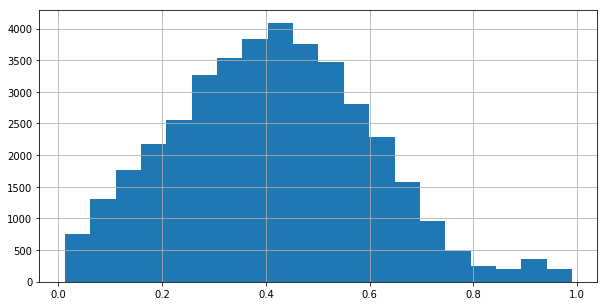

In [274]:
plt.hist(data['model_prob'], bins=20)
plt.grid()

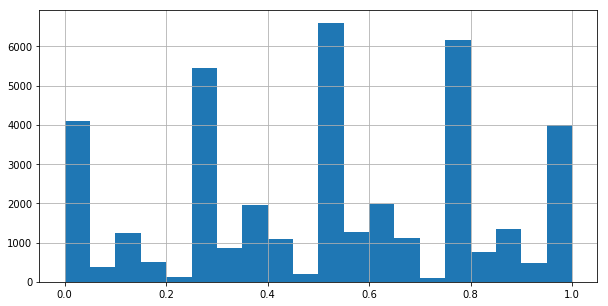

In [275]:
plt.hist(data['systemrank'], bins=20)
plt.grid()

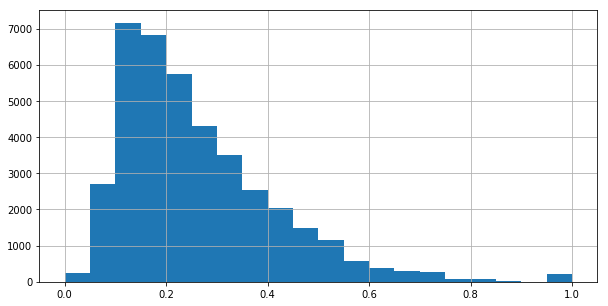

In [276]:
plt.hist(data['bleuScore'], bins=20)
plt.grid()

#### Сравнение по ранжированию

In [8]:
data = pd.read_csv('data/wmt13-data/wmt13-manual-evaluation/wmt13-judgments.csv')

In [10]:
data[data['srclang']=='Russian'].shape

(20831, 21)

In [11]:
# data = pd.read_csv('data/wmt13-data/data_compared.csv')
data[data['srclang']=='Russian'].head()

,srclang,trglang,srcIndex,documentId,segmentId,judgeId,system1Number,system1Id,system2Number,system2Id,system3Number,system3Id,system4Number,system4Id,system5Number,system5Id,system1rank,system2rank,system3rank,system4rank,system5rank
21,Russian,English,479,-1,479,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,-1,newstest2013.ru-en.PROMT.2754,-1,newstest2013.ru-en.CMU-primary.2908,-1,newstest2013.ru-en.OmniFluent_Translate_Russia...,1,3,2,1,3
22,Russian,English,480,-1,480,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,-1,newstest2013.ru-en.PROMT.2754,-1,newstest2013.ru-en.CMU-primary.2908,-1,newstest2013.ru-en.OmniFluent_Translate_Russia...,1,2,3,1,1
23,Russian,English,481,-1,481,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,-1,newstest2013.ru-en.PROMT.2754,-1,newstest2013.ru-en.CMU-primary.2908,-1,newstest2013.ru-en.OmniFluent_Translate_Russia...,1,1,2,1,1
24,Russian,English,2669,-1,2669,researcher_5,-1,newstest2013.ru-en.MES-QCRI:.2843,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,-1,newstest2013.ru-en.cu-zeman.2742,-1,newstest2013.ru-en.QCRI-MES.2856,-1,newstest2013.ru-en.CMU-primary.2908,1,1,1,1,1
25,Russian,English,2670,-1,2670,researcher_5,-1,newstest2013.ru-en.MES-QCRI:.2843,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,-1,newstest2013.ru-en.cu-zeman.2742,-1,newstest2013.ru-en.QCRI-MES.2856,-1,newstest2013.ru-en.CMU-primary.2908,2,2,3,2,1


In [83]:
def tr_to_score_non_lingv(text, model):
    text = text.apply(repl)
    if model == 'FastText':
        X_emb = transform(text, ft_dictn, 500)
    elif model == 'TF-IDF':
        X_emb = vectorizer_tfidf.transform(text)
    elif model == 'Word2Vec':
        X_emb = transform(text, w2v, 500)
    elif model == 'Doc2Vec':
        X_emb = transform(text, d2v, 400)
    elif model == "HAN" or model == 'LSTM' or model =='GRU':
        text = text.apply(repl)
        X_emb = model.transform_data(text, train=False)
    else:
        assert False,'Unknown embedding' 
    return X_emb

In [84]:
def tr_to_score_lingv(text):
    X_list = list(text.apply(repl))
    X_lingv = pd.DataFrame()
    for i, Xi in enumerate(X_list):
        X_lingv = X_lingv.append(ling_features(Xi), ignore_index=True)
        print('Progress: {}/{}'.format(i + 1, len(X_list)), end='\r')
    print('Progress: {}/{}'.format(i + 1, len(X_list)))
    X_lingv = X_lingv[['avg_word_len','n_colons', 'n_commas','n_dots','n_doublequotes','n_excl','n_hyphens','n_numbers',
                       'n_open_brackets','n_questions','n_quotes','n_semicolons','n_tags_DT','n_tags_IN' ,'n_tags_JJ',
                       'n_tags_NN' ,'n_tags_NNS','n_words']]
    X_lingv.fillna(0, inplace=True)
    return X_lingv

In [85]:
def tr_to_score(text, model):
    X_emb = tr_to_score_non_lingv(text, model)
    X_lingv = tr_to_score_lingv(text) 
    
    if model == 'TF-IDF':
        X_to_sc = hstack([X_emb.tocsr(), csr_matrix(X_lingv)]).tocsr()
    else:
        X_to_sc = pd.merge(X_emb, X_lingv, left_index=True, right_index=True)
    return X_to_sc

In [86]:
def gru_model_predict(data, inp_col, out_col):
    print('Inserting spaces around punctuation marks...')
    data[inp_col] = data[inp_col].apply(repl)
    
    print('Transforming data...')
    embedings_test = model.transform_data(data[inp_col], train=False)
    
    print('Predicting...')
    HANmodel = load_model('data/checkpoints/gru-06-0.650.hdf5')
    preds = HANmodel.predict(embedings_test)[:,0]
    data[out_col] = preds

In [87]:
def lstm_model_predict(data, inp_col, out_col):
    print('Inserting spaces around punctuation marks...')
    data[inp_col] = data[inp_col].apply(repl)
    
    print('Transforming data...')
    embedings_test = model.transform_data(data[inp_col], train=False)
    
    print('Predicting...')
    LSTMmodel = load_model('data/checkpoints/lstm-02-0.611.hdf5')
    preds = LSTMmodel.predict(embedings_test)[:,0]
    data[out_col] = preds

In [88]:
def han_model_predict(data, inp_col, out_col):
    print('Inserting spaces around punctuation marks...')
    data[inp_col] = data[inp_col].apply(repl)
    
    print('Transforming data...')
    embedings_test = model.transform_data(data[inp_col], train=False)
    
    print('Predicting...')
    HANmodel = load_model('data/checkpoints/han-06-0.633.hdf5',
                     custom_objects={'Attention': Attention})
    preds = HANmodel.predict(embedings_test)[:,0]
    data[out_col] = preds

In [89]:
def hanlingv_model_predict(data, inp_col, out_col):
    print('Inserting spaces around punctuation marks...')
    data[inp_col] = data[inp_col].apply(repl)
    
    print('Transforming data...')
    embedings_test = model.transform_data(data[inp_col], train=False)
    
    print('Predicting...')
    HANmodel = load_model('data/checkpoints/han_lingv-06-0.642.hdf5',
                     custom_objects={'Attention': Attention})
    X_to_sc = tr_to_score_lingv(data[inp_col])
    preds = HANmodel.predict([embedings_test,X_to_sc])[:,0]
    data[out_col] = preds

In [90]:
def grulingv_model_predict(data, inp_col, out_col):
    print('Inserting spaces around punctuation marks...')
    data[inp_col] = data[inp_col].apply(repl)
    
    print('Transforming data...')
    embedings_test = model.transform_data(data[inp_col], train=False)
    
    print('Predicting...')
    GRUmodel = load_model('data/checkpoints/grulingv-02-0.602.hdf5')
    X_to_sc = tr_to_score_lingv(data[inp_col])
    preds = GRUmodel.predict([embedings_test,X_to_sc])[:,0]
    data[out_col] = preds

In [91]:
def lstmlingv_model_predict(data, inp_col, out_col):
    print('Inserting spaces around punctuation marks...')
    data[inp_col] = data[inp_col].apply(repl)
    
    print('Transforming data...')
    embedings_test = model.transform_data(data[inp_col], train=False)
    
    print('Predicting...')
    LSTMmodel = load_model('data/checkpoints/lstm_lingv-03-0.648.hdf5')
    X_to_sc = tr_to_score_lingv(data[inp_col])
    preds = LSTMmodel.predict([embedings_test,X_to_sc])[:,0]
    data[out_col] = preds

In [92]:
def bleu_score(refSent, outSent):
    refSent = nltk.word_tokenize(refSent)
    outSent = nltk.word_tokenize(outSent)
    return sentence_bleu([refSent], outSent, smoothing_function=SmoothingFunction().method2)

In [93]:
def my_model_non_lingv(data, model, inp_col, out_col):
    X_to_sc2 = tr_to_score_non_lingv(data[inp_col], model)
    if model == 'FastText':
        lgb = joblib.load('non_lingv/ft_500_non_lingv_lgb')
    elif model == 'TF-IDF':
        lgb = joblib.load('non_lingv/tfidf_lgb_non_lingv3')
    elif model == 'Word2Vec':
        lgb = joblib.load('non_lingv/w2v_500_non_lingv')
    elif model == 'Doc2Vec':
        lgb = joblib.load('non_lingv/d2v_400_non_lingv_lgb')
    else:
        assert False,'Unknown embedding' 
    data[out_col] = lgb.predict(X_to_sc2)
    return data

In [94]:
def my_model_lingv(data, model, inp_col, out_col):
    X_to_sc = tr_to_score_lingv(data[inp_col])
    lgb = joblib.load('lingv/lgb_model') 
    data[out_col] = lgb.predict(X_to_sc)
    return data

In [153]:

model2 = Simple_model()
embedings = model2.transform_data(X_train['english'])

Loading word2vec model...
Total: 138550 documents

Clearing and tokenizing data...


Getting embeddings...

Embeddings shape: (138550, 90)
Unique words: 34216
Maximum words in a sentence: 90



In [95]:
def my_model_mixed(data, model, inp_col, out_col):
    if model != 'HAN' and model != 'GRU' and model != 'LSTM':
        X_to_sc2 = tr_to_score_non_lingv(data[inp_col], model)
    if model == 'FastText':
        alpha = 0.938
        lgb = joblib.load('non_lingv/ft_500_non_lingv_lgb')
    elif model == 'TF-IDF':
        alpha = 0.217
        lgb = joblib.load('non_lingv/tfidf_lr_non_lingv_3')
    elif model == 'Word2Vec':
        alpha = 1
        lgb = joblib.load('non_lingv/w2v_500_non_lingv')
    elif model == 'Doc2Vec':
        alpha = 0.922
        lgb = joblib.load('non_lingv/d2v_400_non_lingv_lgb')
    elif model == 'HAN':
        alpha = 0.558
    elif model == 'GRU':
        alpha = 0.511
    elif model == 'LSTM':
        alpha = 0.6
    else:
        assert False,'Unknown embedding' 
    
        
    if model != 'HAN' and model != 'GRU' and model != 'LSTM':
        pred = lgb.predict(X_to_sc2)
    elif model == 'LSTM':
        embedings_test = model2.transform_data(data[inp_col], train=False)
        LSTMmodel = load_model('data/checkpoints/lstm-02-0.611.hdf5')
        pred = LSTMmodel.predict(embedings_test)[:,0]
    elif model == 'GRU':
        embedings_test = model2.transform_data(data[inp_col], train=False)
        LSTMmodel = load_model('data/checkpoints/gru-06-0.650.hdf5')
        pred = LSTMmodel.predict(embedings_test)[:,0]
    elif model == 'HAN':
        embedings_test = model2.transform_data(data[inp_col], train=False)
        LSTMmodel = load_model('data/checkpoints/han-06-0.633.hdf5')
        pred = LSTMmodel.predict(embedings_test)[:,0]
            
    X_to_sc = tr_to_score_lingv(data[inp_col])
    lgb = joblib.load('lingv/lgb_model') 
    l_pred = lgb.predict(X_to_sc)
    
    data[out_col] = alpha * pred + (1-alpha) *  l_pred
    return data

In [96]:
def my_model(data, model, inp_col, out_col):
    X_to_sc2 = tr_to_score(data[inp_col], model)
    if model == 'FastText':
        lgb = joblib.load('all_new/all_model_ft')
    elif model == 'TF-IDF':
        lgb = joblib.load('all_new/all_model_tfidf_lgb2')
    elif model == 'Word2Vec':
        lgb = joblib.load('all_new/all_model_w2v')
    elif model == 'Doc2Vec':
        lgb = joblib.load('all_new/all_model_d2v')
    else:
        assert False,'Unknown embedding' 
    data[out_col] = lgb.predict(X_to_sc2)
    return data

In [38]:
def get_data(input_dir):
    man_eval = pd.read_csv(os.path.join(input_dir, 'wmt13-manual-evaluation/wmt13-judgments.csv'))
    print('Overall judgments: {}'.format(man_eval.shape[0]))
    judgments = man_eval[(man_eval['srclang'] == 'Russian') & (man_eval['trglang'] == 'English')]\
                                        .reset_index(drop=True)
    print('Russian to English judgments: {}'.format(judgments.shape[0]))
    
    print('Dropping no rankings...')
    judgments = judgments[judgments['system1rank'] != -1].reset_index(drop=True)
    print('\tShape: {}'.format(judgments.shape))
    
    with open(os.path.join(input_dir, 'plain/references/newstest2013-ref.en'), encoding='utf-8') as f:
        ref = [line.strip() for line in f]
    with open(os.path.join(input_dir, 'plain/sources/newstest2013-src.ru'), encoding='utf-8') as f:
        sources = [line.strip() for line in f]
    print('Russian to English sentences: {}'.format(len(sources)))
    
    outputs = {}
    out_dir = os.path.join(input_dir, 'plain/system-outputs/newstest2013/ru-en')
    for filename in os.listdir(out_dir):
        try:
            with open(os.path.join(out_dir, filename), encoding='utf-8') as f:
                outputs[filename] = [line.strip() for line in f]
        except:
            with open(os.path.join(out_dir, filename), encoding='cp1252') as f:
                outputs[filename] = [line.strip() for line in f]
                
    print('Translation systems: {}'.format(len(outputs)))
    judgments['system1Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system2Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system3Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system4Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    judgments['system5Id'].replace({'newstest2013.ru-en.MES-QCRI:.2843':'newstest2013.ru-en.MES-QCRI_.2843'}, inplace=True)
    
    for i in judgments.index:
        srcIndex = judgments.loc[i, 'srcIndex']
        for systemId in range(5):
            judgments.loc[i, 'srcSent'] = sources[srcIndex - 1]
            judgments.loc[i, 'refSent'] = ref[srcIndex - 1]
            outSent_col = 'system{}Sent'.format(systemId + 1)
            judgments.loc[i, outSent_col] = outputs[judgments.loc[i, 'system{}Id'.\
                                                                        format(systemId + 1)]][srcIndex - 1]
            # for model prediction
            judgments.loc[i, outSent_col] = judgments.loc[i, outSent_col]\
                                                            .replace('<S>', '').replace('</S>', '').\
                                                            replace('<s>', '').replace('</s>', '').strip()        
        print('Progress: {}/{}'.format(i + 1, judgments.shape[0]), end='\r')
    print('Progress: {}/{}'.format(i + 1, judgments.shape[0]))
    
    return judgments

In [81]:
data = get_data(input_dir='data/wmt13-data')

Overall judgments: 126224
Russian to English judgments: 20831
Dropping no rankings...
	Shape: (20024, 21)
Russian to English sentences: 3000
Translation systems: 23
Progress: 20024/20024


In [130]:
def convert_prob(probs):
    max_diff = max(probs) - min(probs)
    max_diff = max_diff if max_diff != 0 else 1
    
    ranks = [0] * len(probs)
    cnt = 0
    idx = list(reversed(np.argsort(np.array(probs))))
    for i in range(len(idx)):
        if i == 0 or np.abs(probs[idx[i]] - probs[idx[i - 1]]) / max_diff > 0.15:
            cnt += 1
        ranks[idx[i]] = cnt
    return ranks

In [98]:
def rmse(list1, list2):
    return np.sqrt(np.mean((np.array(list1) - np.array(list2)) ** 2))

In [99]:
def mae(list1, list2):
    return np.mean(np.abs(np.array(list1) - np.array(list2)))

In [85]:
data.head()

,srclang,trglang,srcIndex,documentId,segmentId,judgeId,system1Number,system1Id,system2Number,system2Id,...,system3rank,system4rank,system5rank,srcSent,refSent,system1Sent,system2Sent,system3Sent,system4Sent,system5Sent
0,Russian,English,479,-1,479,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,2,1,3,"Они указывают в особенности на статью 220, кот...","They refer in particular to article 220, which...","They point out in particular to Article 220, w...","They point in particular to Article 220, which...","They point in particular Article 220, which gi...","They point in particular to Article 220, which...","They point notably in Article 220, which will ..."
1,Russian,English,480,-1,480,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,3,1,1,"По словам специалиста по Египту Софи Помье, эт...","According to Egypt specialist Sophie Pommier, ...",According to Sophie Sophie specialist in Egypt...,According to the specialist in Egypt Sophie Po...,According to a specialist in Egypt Sophie Pomy...,According to the specialist Egypt Sophie Pommi...,According to an expert on Egypt's Sophie Pommi...
2,Russian,English,481,-1,481,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,2,1,1,"Мы можем наблюдать зарождение теократии"".","This suggests the beginnings of a theocracy.""","We can see a theocracy. ""","We see the emergence of theocracy. ""","We can observe theocracy origin "".","We can see the emergence of a theocracy. ""","We are seeing the emergence of a theocracy ."""
3,Russian,English,2669,-1,2669,researcher_5,-1,newstest2013.ru-en.MES-QCRI_.2843,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,1,1,1,Хосе стал последователем Ask после прочтения р...,"Joseph became a follower on Ask, after reading...",Jose became a follower of ask after reading re...,Jose became a follower ask after reading recom...,José has become a follower of Ask after readin...,Jose became a follower of ask after reading th...,Jose became a follower of ask after reading th...
4,Russian,English,2670,-1,2670,researcher_5,-1,newstest2013.ru-en.MES-QCRI_.2843,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,3,2,1,"Мальчику не чужд опыт того, что сегодня извест...",This teenager is not alien to experiences of w...,The boy is not alien experience that today is ...,The boy is not alien to experience what is kno...,A boy not strange experience that now known as...,The boy is no stranger to the experience of wh...,The boy is no stranger to the experience of wh...


In [123]:
def compare_data(data):
    for i in range(1, 6):
        data['system{}Sent'.format(i)] = data['system{}Sent'.format(i)].apply(str)
    
    print('FastText lingv predicting...\n')
    for systemId in range(1, 6):
        data.loc[data['system{}Sent'.format(systemId)].apply(repl).apply(lambda x: len(x.split())==0), 
                 'system{}Sent'.format(systemId)] = 'Unknown'
        data = my_model(data, 'FastText', 'system{}Sent'.format(systemId), 'ft_lingv_prob{}'.format(systemId))
    
    print('\nTF-IDF predicting...\n')
    for systemId in range(1, 6):
        data = my_model(data, 'TF-IDF', 'system{}Sent'.format(systemId), 'tfidf_lingv_prob{}'.format(systemId))    
        
    print('\nWord2Vec predicting...\n')
    for systemId in range(1, 6):
        data = my_model(data, 'Word2Vec', 'system{}Sent'.format(systemId), 'w2v_lingv_prob{}'.format(systemId))   
        
    print('\nDoc2Vec predicting...\n')
    for systemId in range(1, 6):
        data = my_model(data, 'Doc2Vec', 'system{}Sent'.format(systemId), 'd2v_lingv_prob{}'.format(systemId))    

    print('\nWord2Vec non_lingv predicting...\n')
    for systemId in range(1, 6):
        data = my_model_non_lingv(data, 'Word2Vec', 'system{}Sent'.format(systemId), 'w2v_n_l_prob{}'.format(systemId))  
        
    print('\TF-IDF non_lingv predicting...\n')
    for systemId in range(1, 6):
        data = my_model_non_lingv(data, 'TF-IDF', 'system{}Sent'.format(systemId), 'tfidf_n_l_prob{}'.format(systemId))  
        
    print('\nFastText non_lingv predicting...\n')
    for systemId in range(1, 6):
        data = my_model_non_lingv(data, 'FastText', 'system{}Sent'.format(systemId), 'fasttext_n_l_prob{}'.format(systemId))  
        
    print('\nDoc2Vec non_lingv predicting...\n')
    for systemId in range(1, 6):
        data = my_model_non_lingv(data, 'Doc2Vec', 'system{}Sent'.format(systemId), 'd2v_n_l_prob{}'.format(systemId))  
        
    print('\nWord2Vec mixed predicting...\n')
    for systemId in range(1, 6):
        data = my_model_mixed(data, 'Word2Vec', 'system{}Sent'.format(systemId), 'w2v_mixed_prob{}'.format(systemId))  
        
    print('\TF-IDF mixed predicting...\n')
    for systemId in range(1, 6):
        data = my_model_mixed(data, 'TF-IDF', 'system{}Sent'.format(systemId), 'tfidf_mixed_prob{}'.format(systemId))  
        
    print('\FastText mixed predicting...\n')
    for systemId in range(1, 6):
        data = my_model_mixed(data, 'FastText', 'system{}Sent'.format(systemId), 'fasttext_mixed_prob{}'.format(systemId))  
        
    print('\nDoc2Vec mixed predicting...\n')
    for systemId in range(1, 6):
        data = my_model_mixed(data, 'Doc2Vec', 'system{}Sent'.format(systemId), 'd2v_mixed_prob{}'.format(systemId))  
        
    print('\nHAN mixed predicting...\n')
    for systemId in range(1, 6):
        data = my_model_mixed(data, 'HAN', 'system{}Sent'.format(systemId), 'han_mixed_prob{}'.format(systemId))  
        
    print('\nGRU mixed predicting...\n')
    for systemId in range(1, 6):
        data = my_model_mixed(data, 'GRU', 'system{}Sent'.format(systemId), 'gru_mixed_prob{}'.format(systemId))  
        
    print('\nLSTM mixed predicting...\n')
    for systemId in range(1, 6):
        data = my_model_mixed(data, 'LSTM', 'system{}Sent'.format(systemId), 'lstm_mixed_prob{}'.format(systemId))  
         
    print('\nOnly Lingvistic predicting...\n')
    for systemId in range(1, 6):
        data = my_model_lingv(data, 'Lingv', 'system{}Sent'.format(systemId), 'lingv_prob{}'.format(systemId))   
    
    print('\nBleu scoring...\n')
    for i in data.index:
        for systemId in range(1, 6):
            data.loc[i, 'bleu{}'.format(systemId)] = bleu_score(data.loc[i, 'refSent'],
                                                                data.loc[i, 'system{}Sent'.format(systemId)])
        print('Progress: {}/{}'.format(i + 1, data.shape[0]), end='\r')
    print('Progress: {}/{}'.format(i + 1, data.shape[0]))

    print('GRU model predicting...\n')
    for systemId in range(1, 6):
        gru_model_predict(data, 'system{}Sent'.format(systemId), 'gru_model_prob{}'.format(systemId))
    
    print('GRUlingv model predicting...\n')
    for systemId in range(1, 6):
        grulingv_model_predict(data, 'system{}Sent'.format(systemId), 'grulingv_model_prob{}'.format(systemId))

    print('HAN model predicting...\n')
    for systemId in range(1, 6):
        han_model_predict(data, 'system{}Sent'.format(systemId), 'han_model_prob{}'.format(systemId))

    print('HANlingv model predicting...\n')
    for systemId in range(1, 6):
        hanlingv_model_predict(data, 'system{}Sent'.format(systemId), 'hanlingv_model_prob{}'.format(systemId))
        
    print('LSTMlingv model predicting...\n')
    for systemId in range(1, 6):
        lstmlingv_model_predict(data, 'system{}Sent'.format(systemId), 'lstmlingv_model_prob{}'.format(systemId))
        
    print('LSTM model predicting...\n')
    for systemId in range(1, 6):
        lstm_model_predict(data, 'system{}Sent'.format(systemId), 'lstm_model_prob{}'.format(systemId))
    
    print('\nComparing data...')
    ranks = []
    for i in tqdm(data.index):
        ft_lingv_ranks = convert_prob(list(data.loc[i, 'ft_lingv_prob1':'ft_lingv_prob5']))
        tfidf_lingv_ranks = convert_prob(list(data.loc[i, 'tfidf_lingv_prob1':'tfidf_lingv_prob5']))
        w2v_lingv_ranks = convert_prob(list(data.loc[i, 'w2v_lingv_prob1':'w2v_lingv_prob5']))
        d2v_lingv_ranks = convert_prob(list(data.loc[i, 'd2v_lingv_prob1':'d2v_lingv_prob5']))
        
        w2v_n_l_ranks = convert_prob(list(data.loc[i, 'w2v_n_l_prob1':'w2v_n_l_prob5']))
        tfidf_n_l_ranks = convert_prob(list(data.loc[i, 'tfidf_n_l_prob1':'tfidf_n_l_prob5']))
        fasttext_n_l_ranks = convert_prob(list(data.loc[i, 'fasttext_n_l_prob1':'fasttext_n_l_prob5']))
        d2v_n_l_ranks = convert_prob(list(data.loc[i, 'd2v_n_l_prob1':'d2v_n_l_prob5']))
        
        w2v_mixed_ranks = convert_prob(list(data.loc[i, 'w2v_mixed_prob1':'w2v_mixed_prob5']))
        tfidf_mixed_ranks = convert_prob(list(data.loc[i, 'tfidf_mixed_prob1':'tfidf_mixed_prob5']))
        fasttext_mixed_ranks = convert_prob(list(data.loc[i, 'fasttext_mixed_prob1':'fasttext_mixed_prob5']))
        d2v_mixed_ranks = convert_prob(list(data.loc[i, 'd2v_mixed_prob1':'d2v_mixed_prob5']))
        han_mixed_ranks = convert_prob(list(data.loc[i, 'han_mixed_prob1':'han_mixed_prob5']))
        gru_mixed_ranks = convert_prob(list(data.loc[i, 'gru_mixed_prob1':'gru_mixed_prob5']))
        lstm_mixed_ranks = convert_prob(list(data.loc[i, 'lstm_mixed_prob1':'lstm_mixed_prob5']))

        lingv_ranks = convert_prob(list(data.loc[i, 'lingv_prob1':'lingv_prob5']))
        
        system_ranks = list(data.loc[i, 'system1rank':'system5rank'])
        bleu_ranks = convert_prob(list(data.loc[i, 'bleu1':'bleu5']))
        gru_ranks = convert_prob(list(data.loc[i, 'gru_model_prob1':'gru_model_prob5']))
        grulingv_ranks = convert_prob(list(data.loc[i, 'grulingv_model_prob1':'grulingv_model_prob5']))
        lstmlingv_ranks = convert_prob(list(data.loc[i, 'lstmlingv_model_prob1':'lstmlingv_model_prob5']))
        han_ranks = convert_prob(list(data.loc[i, 'han_model_prob1':'han_model_prob5']))
        hanlingv_ranks = convert_prob(list(data.loc[i, 'hanlingv_model_prob1':'hanlingv_model_prob5']))
        lstm_ranks = convert_prob(list(data.loc[i, 'lstm_model_prob1':'lstm_model_prob5']))
        ranks.append(system_ranks + w2v_n_l_ranks + tfidf_n_l_ranks + fasttext_n_l_ranks + d2v_n_l_ranks +
                     lingv_ranks + bleu_ranks + gru_ranks  + han_ranks + lstm_ranks + ft_lingv_ranks + 
                     tfidf_lingv_ranks + w2v_lingv_ranks + d2v_lingv_ranks + hanlingv_ranks + lstmlingv_ranks 
                     + grulingv_ranks + w2v_mixed_ranks + tfidf_mixed_ranks + fasttext_mixed_ranks + d2v_mixed_ranks + 
                     han_mixed_ranks + gru_mixed_ranks + lstm_mixed_ranks)
                     
        
        data.loc[i, 'ft_lingv_rmse'] = rmse(ft_lingv_ranks, system_ranks)
        data.loc[i, 'tfidf_lingv_rmse'] = rmse(tfidf_lingv_ranks, system_ranks)
        data.loc[i, 'w2v_lingv_rmse'] = rmse(w2v_lingv_ranks, system_ranks)
        data.loc[i, 'd2v_lingv_rmse'] = rmse(d2v_lingv_ranks, system_ranks)
        data.loc[i, 'w2v_n_l_rmse'] = rmse(w2v_n_l_ranks, system_ranks)
        data.loc[i, 'd2v_n_l_rmse'] = rmse(d2v_n_l_ranks, system_ranks)
        data.loc[i, 'tfidf_n_l_rmse'] = rmse(tfidf_n_l_ranks, system_ranks)
        data.loc[i, 'fasttext_n_l_rmse'] = rmse(fasttext_n_l_ranks, system_ranks)
        data.loc[i, 'w2v_mixed_rmse'] = rmse(w2v_mixed_ranks, system_ranks)
        data.loc[i, 'd2v_mixed_rmse'] = rmse(d2v_mixed_ranks, system_ranks)
        data.loc[i, 'tfidf_mixed_rmse'] = rmse(tfidf_mixed_ranks, system_ranks)
        data.loc[i, 'fasttext_mixed_rmse'] = rmse(fasttext_mixed_ranks, system_ranks)
        data.loc[i, 'han_mixed_rmse'] = rmse(han_mixed_ranks, system_ranks)
        data.loc[i, 'gru_mixed_rmse'] = rmse(gru_mixed_ranks, system_ranks)
        data.loc[i, 'lstm_mixed_rmse'] = rmse(lstm_mixed_ranks, system_ranks)
        data.loc[i, 'lingv_rmse'] = rmse(lingv_ranks, system_ranks)
        data.loc[i, 'gru_rmse'] = rmse(gru_ranks, system_ranks)
        data.loc[i, 'grulingv_rmse'] = rmse(grulingv_ranks, system_ranks)
        data.loc[i, 'bleu_rmse'] = rmse(bleu_ranks, system_ranks)
        data.loc[i, 'han_rmse'] = rmse(han_ranks, system_ranks)
        data.loc[i, 'hanlingv_rmse'] = rmse(hanlingv_ranks, system_ranks)
        data.loc[i, 'lstmlingv_rmse'] = rmse(lstmlingv_ranks, system_ranks)
        data.loc[i, 'lstm_rmse'] = rmse(lstm_ranks, system_ranks)
        data.loc[i, 'constant_rmse'] = rmse([1]*5, system_ranks)
    
        data.loc[i, 'ft_lingv_mae'] = mae(ft_lingv_ranks, system_ranks)
        data.loc[i, 'tfidf_lingv_mae'] = mae(tfidf_lingv_ranks, system_ranks)
        data.loc[i, 'w2v_lingv_mae'] = mae(w2v_lingv_ranks, system_ranks)
        data.loc[i, 'd2v_lingv_mae'] = mae(d2v_lingv_ranks, system_ranks)
        data.loc[i, 'w2v_n_l_mae'] = mae(w2v_n_l_ranks, system_ranks)
        data.loc[i, 'd2v_n_l_mae'] = mae(d2v_n_l_ranks, system_ranks)
        data.loc[i, 'tfidf_n_l_mae'] = mae(tfidf_n_l_ranks, system_ranks)
        data.loc[i, 'fasttext_n_l_mae'] = mae(fasttext_n_l_ranks, system_ranks)
        data.loc[i, 'w2v_mixed_mae'] = mae(w2v_mixed_ranks, system_ranks)
        data.loc[i, 'd2v_mixed_mae'] = mae(d2v_mixed_ranks, system_ranks)
        data.loc[i, 'tfidf_mixed_mae'] = mae(tfidf_mixed_ranks, system_ranks)
        data.loc[i, 'fasttext_mixed_mae'] = mae(fasttext_mixed_ranks, system_ranks)
        data.loc[i, 'han_mixed_mae'] = mae(han_mixed_ranks, system_ranks)
        data.loc[i, 'gru_mixed_mae'] = mae(gru_mixed_ranks, system_ranks)
        data.loc[i, 'lstm_mixed_mae'] = mae(lstm_mixed_ranks, system_ranks)
        data.loc[i, 'lingv_mae'] = mae(lingv_ranks, system_ranks)
        data.loc[i, 'bleu_mae'] = mae(bleu_ranks, system_ranks)
        data.loc[i, 'gru_mae'] = mae(gru_ranks, system_ranks)
        data.loc[i, 'grulingv_mae'] = mae(grulingv_ranks, system_ranks)
        data.loc[i, 'han_mae'] = mae(han_ranks, system_ranks)
        data.loc[i, 'hanlingv_mae'] = mae(hanlingv_ranks, system_ranks)
        data.loc[i, 'lstmlingv_mae'] = mae(lstmlingv_ranks, system_ranks)
        data.loc[i, 'lstm_mae'] = mae(lstm_ranks, system_ranks)
        data.loc[i, 'constant_mae'] = mae([1]*5, system_ranks)
        
        data.loc[i, 'ft_lingv_acc'] = accuracy_score(ft_lingv_ranks, system_ranks)
        data.loc[i, 'tfidf_lingv_acc'] = accuracy_score(tfidf_lingv_ranks, system_ranks)
        data.loc[i, 'w2v_lingv_acc'] = accuracy_score(w2v_lingv_ranks, system_ranks)
        data.loc[i, 'd2v_lingv_acc'] = accuracy_score(d2v_lingv_ranks, system_ranks)
        data.loc[i, 'w2v_n_l_acc'] = accuracy_score(w2v_n_l_ranks, system_ranks)
        data.loc[i, 'd2v_n_l_acc'] = accuracy_score(d2v_n_l_ranks, system_ranks)
        data.loc[i, 'tfidf_n_l_acc'] = accuracy_score(tfidf_n_l_ranks, system_ranks)
        data.loc[i, 'fasttext_n_l_acc'] = accuracy_score(fasttext_n_l_ranks, system_ranks)
        data.loc[i, 'w2v_mixed_acc'] = accuracy_score(w2v_mixed_ranks, system_ranks)
        data.loc[i, 'd2v_mixed_acc'] = accuracy_score(d2v_mixed_ranks, system_ranks)
        data.loc[i, 'tfidf_mixed_acc'] = accuracy_score(tfidf_mixed_ranks, system_ranks)
        data.loc[i, 'fasttext_mixed_acc'] = accuracy_score(fasttext_mixed_ranks, system_ranks)
        data.loc[i, 'han_mixed_acc'] = accuracy_score(han_mixed_ranks, system_ranks)
        data.loc[i, 'gru_mixed_acc'] = accuracy_score(gru_mixed_ranks, system_ranks)
        data.loc[i, 'lstm_mixed_acc'] = accuracy_score(lstm_mixed_ranks, system_ranks)
        data.loc[i, 'lingv_acc'] = accuracy_score(lingv_ranks, system_ranks)
        data.loc[i, 'bleu_acc'] = accuracy_score(bleu_ranks, system_ranks)
        data.loc[i, 'gru_acc'] = accuracy_score(gru_ranks, system_ranks)
        data.loc[i, 'grulingv_acc'] = accuracy_score(grulingv_ranks, system_ranks)
        data.loc[i, 'han_acc'] = accuracy_score(han_ranks, system_ranks)
        data.loc[i, 'hanlingv_acc'] = accuracy_score(hanlingv_ranks, system_ranks)
        data.loc[i, 'lstmlingv_acc'] = accuracy_score(lstmlingv_ranks, system_ranks)
        data.loc[i, 'lstm_acc'] = accuracy_score(lstm_ranks, system_ranks)
        data.loc[i, 'constant_acc'] = accuracy_score([1]*5, system_ranks)
        

        columns = ['{}{}'.format(mod, i) for mod in ['system', 'w2v_n_l', 'tfidf_n_l', 'fasttext_n_l', 'd2v_n_l', 'lingv', 'bleu', 'gru','han', 'lstm', 'ft_lingv', 'tfidf_lingv', 'w2v_lingv', 'd2v_lingv', 'hanlingv', 'lstmlingv', 'grulingv', 'w2v_mixed', 'tfidf_mixed', 'fasttext_mixed', 'd2v_mixed', 'han_mixed', 'gru_mixed', 'lstm_mixed']\
               for i in range(1, 6)]
    ranks = pd.DataFrame(ranks, columns=columns)
    
    return ranks

In [131]:
ranks = compare_data(data)


Comparing data...


100%|████████████████████████████████████████████████████████████████████████████| 20024/20024 [32:25<00:00,  8.96it/s]


In [132]:
#0.15
test_df = pd.DataFrame(columns=["Model", "rMSE", "MAE", "Acc"], index=np.arange(24))
test_df.loc[0][0] = "Non Lingv w2v"
test_df.loc[1][0] = "Non Lingv tfidf"
test_df.loc[2][0] = "Non Lingv fasttext"
test_df.loc[3][0] = "Non Lingv d2v"
test_df.loc[4][0] = "Only Lingv"
test_df.loc[5][0] = "GRU"
test_df.loc[6][0] = "HAN"
test_df.loc[7][0] = "LSTM"

test_df.loc[8][0] = "FastText lingv"
test_df.loc[9][0] = "TF-IDF lingv"
test_df.loc[10][0] = "w2v lingv"
test_df.loc[11][0] = "d2v lingv"
test_df.loc[12][0] = "GRU lingv"
test_df.loc[13][0] = "HAN lingv"
test_df.loc[14][0] = "LSTM lingv"
test_df.loc[15][0] = "FastText Mixed"
test_df.loc[16][0] = "TF-IDF Mixed"
test_df.loc[17][0] = "w2v Mixed"
test_df.loc[18][0] = "d2v Mixed"
test_df.loc[19][0] = "GRU Mixed"
test_df.loc[20][0] = "HAN Mixed"
test_df.loc[21][0] = "LSTM Mixed"
test_df.loc[22][0] = "BLEU"
test_df.loc[23][0] = "Constant"

test_df.iloc[0][1] = data['w2v_n_l_rmse'].mean()
test_df.iloc[1][1] = data['tfidf_n_l_rmse'].mean()
test_df.iloc[2][1] = data['fasttext_n_l_rmse'].mean()
test_df.iloc[3][1] = data['d2v_n_l_rmse'].mean()
test_df.iloc[4][1] = data['lingv_rmse'].mean()
test_df.iloc[5][1] = data['gru_rmse'].mean()
test_df.iloc[6][1] = data['han_rmse'].mean()
test_df.iloc[7][1] = data['lstm_rmse'].mean()
test_df.iloc[8][1] = data['ft_lingv_rmse'].mean()
test_df.iloc[9][1] = data['tfidf_lingv_rmse'].mean()
test_df.iloc[10][1] = data['w2v_lingv_rmse'].mean()
test_df.iloc[11][1] = data['d2v_lingv_rmse'].mean()
test_df.iloc[12][1] = data['grulingv_rmse'].mean()
test_df.iloc[13][1] = data['hanlingv_rmse'].mean()
test_df.iloc[14][1] = data['lstmlingv_rmse'].mean()
test_df.iloc[8][1] = data['ft_lingv_rmse'].mean()
test_df.iloc[9][1] = data['tfidf_lingv_rmse'].mean()
test_df.iloc[10][1] = data['w2v_lingv_rmse'].mean()
test_df.iloc[11][1] = data['d2v_lingv_rmse'].mean()
test_df.iloc[12][1] = data['grulingv_rmse'].mean()
test_df.iloc[13][1] = data['hanlingv_rmse'].mean()
test_df.iloc[14][1] = data['lstmlingv_rmse'].mean()
test_df.loc[15][1] = data['fasttext_mixed_rmse'].mean()
test_df.loc[16][1] = data['tfidf_mixed_rmse'].mean()
test_df.loc[17][1] = data['w2v_mixed_rmse'].mean()
test_df.loc[18][1] = data['d2v_mixed_rmse'].mean()
test_df.loc[19][1] = data['gru_mixed_rmse'].mean()
test_df.loc[20][1] = data['han_mixed_rmse'].mean()
test_df.loc[21][1] = data['lstm_mixed_rmse'].mean()
test_df.iloc[22][1] = data['bleu_rmse'].mean()
test_df.iloc[23][1] = data['constant_rmse'].mean()

test_df.iloc[0][2] = data['w2v_n_l_mae'].mean()
test_df.iloc[1][2] = data['tfidf_n_l_mae'].mean()
test_df.iloc[2][2] = data['fasttext_n_l_mae'].mean()
test_df.iloc[3][2] = data['d2v_n_l_mae'].mean()
test_df.iloc[4][2] = data['lingv_mae'].mean()
test_df.iloc[5][2] = data['gru_mae'].mean()
test_df.iloc[6][2] = data['han_mae'].mean()
test_df.iloc[7][2] = data['lstm_mae'].mean()
test_df.iloc[8][2] = data['ft_lingv_mae'].mean()
test_df.iloc[9][2] = data['tfidf_lingv_mae'].mean()
test_df.iloc[10][2] = data['w2v_lingv_mae'].mean()
test_df.iloc[11][2] = data['d2v_lingv_mae'].mean()
test_df.iloc[12][2] = data['grulingv_mae'].mean()
test_df.iloc[13][2] = data['hanlingv_mae'].mean()
test_df.iloc[14][2] = data['lstmlingv_mae'].mean()
test_df.loc[15][2] = data['fasttext_mixed_mae'].mean()
test_df.loc[16][2] = data['tfidf_mixed_mae'].mean()
test_df.loc[17][2] = data['w2v_mixed_mae'].mean()
test_df.loc[18][2] = data['d2v_mixed_mae'].mean()
test_df.loc[19][2] = data['gru_mixed_mae'].mean()
test_df.loc[20][2] = data['han_mixed_mae'].mean()
test_df.loc[21][2] = data['lstm_mixed_mae'].mean()
test_df.iloc[22][2] = data['bleu_mae'].mean()
test_df.iloc[23][2] = data['constant_mae'].mean()



test_df.iloc[0][3] = data['w2v_n_l_acc'].mean()
test_df.iloc[1][3] = data['tfidf_n_l_acc'].mean()
test_df.iloc[2][3] = data['fasttext_n_l_acc'].mean()
test_df.iloc[3][3] = data['d2v_n_l_acc'].mean()
test_df.iloc[4][3] = data['lingv_acc'].mean()
test_df.iloc[5][3] = data['gru_acc'].mean()
test_df.iloc[6][3] = data['han_acc'].mean()
test_df.iloc[7][3] = data['lstm_acc'].mean()
test_df.iloc[8][3] = data['ft_lingv_acc'].mean()
test_df.iloc[9][3] = data['tfidf_lingv_acc'].mean()
test_df.iloc[10][3] = data['w2v_lingv_acc'].mean()
test_df.iloc[11][3] = data['d2v_lingv_acc'].mean()
test_df.iloc[12][3] = data['grulingv_acc'].mean()
test_df.iloc[13][3] = data['hanlingv_acc'].mean()
test_df.iloc[14][3] = data['lstmlingv_acc'].mean()
test_df.loc[15][3] = data['fasttext_mixed_acc'].mean()
test_df.loc[16][3] = data['tfidf_mixed_acc'].mean()
test_df.loc[17][3] = data['w2v_mixed_acc'].mean()
test_df.loc[18][3] = data['d2v_mixed_acc'].mean()
test_df.loc[19][3] = data['gru_mixed_acc'].mean()
test_df.loc[20][3] = data['han_mixed_acc'].mean()
test_df.loc[21][3] = data['lstm_mixed_acc'].mean()
test_df.iloc[22][3] = data['bleu_acc'].mean()
test_df.iloc[23][3] = data['constant_acc'].mean()

test_df

,Model,rMSE,MAE,Acc
0,Non Lingv w2v,1.75834,1.46733,0.215571
1,Non Lingv tfidf,1.77973,1.48426,0.217549
2,Non Lingv fasttext,1.76771,1.47358,0.215801
3,Non Lingv d2v,1.77548,1.48252,0.214622
4,Only Lingv,1.79399,1.49866,0.213054
5,GRU,1.76335,1.4709,0.21651
6,HAN,1.77209,1.47836,0.216051
7,LSTM,1.7804,1.48671,0.214493
8,FastText lingv,1.75832,1.46722,0.217259
9,TF-IDF lingv,1.7683,1.47511,0.214153


In [135]:
test_df.to_excel('results_0.15.xlsx')

In [105]:
data.to_pickle('0106_results')

Ничьи

In [157]:
convert_prob(list([0.47236654,0.042300824, 0.42272133, 0.2301149, 0.334104]))

[1, 4, 1, 3, 2]

In [160]:
convert_prob(list([0.44785547,0.37106198, 0.5173653, 0.6736125, 0.5427721]))

[3, 4, 2, 1, 2]

In [104]:
# data = pd.read_pickle('0106_results')

In [168]:
data.head()

,srclang,trglang,srcIndex,documentId,segmentId,judgeId,system1Number,system1Id,system2Number,system2Id,...,han_mixed_mae,gru_mixed_mae,lstm_mixed_mae,w2v_mixed_acc,d2v_mixed_acc,tfidf_mixed_acc,fasttext_mixed_acc,han_mixed_acc,gru_mixed_acc,lstm_mixed_acc
0,Russian,English,479,-1,479,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,0.4,0.4,0.4,0.0,0.2,0.6,0.4,0.6,0.6,0.6
1,Russian,English,480,-1,480,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,0.8,1.0,0.8,0.2,0.4,0.6,0.2,0.2,0.4,0.2
2,Russian,English,481,-1,481,researcher_5,-1,newstest2013.ru-en.umd.2892,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,1.0,1.6,1.0,0.4,0.4,0.4,0.4,0.6,0.2,0.6
3,Russian,English,2669,-1,2669,researcher_5,-1,newstest2013.ru-en.MES-QCRI_.2843,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,1.0,1.8,1.0,0.4,0.2,0.2,0.2,0.4,0.2,0.4
4,Russian,English,2670,-1,2670,researcher_5,-1,newstest2013.ru-en.MES-QCRI_.2843,-1,newstest2013.ru-en.UCAM_primary_multifrontend....,...,0.8,0.8,0.8,0.2,0.2,0.2,0.2,0.4,0.2,0.4


In [170]:
test_df.style.apply(lambda x: ['background: lightgreen' if x.name in [12]  else 'background: lightblue' if x.name in [22] \
                               else '' for i in x], axis=1)

,Model,rMSE,MAE,Acc
0,Non Lingv w2v,1.75834,1.46733,0.215571
1,Non Lingv tfidf,1.77973,1.48426,0.217549
2,Non Lingv fasttext,1.76771,1.47358,0.215801
3,Non Lingv d2v,1.77548,1.48252,0.214622
4,Only Lingv,1.79399,1.49866,0.213054
5,GRU,1.76335,1.4709,0.21651
6,HAN,1.77209,1.47836,0.216051
7,LSTM,1.7804,1.48671,0.214493
8,FastText lingv,1.75832,1.46722,0.217259
9,TF-IDF lingv,1.7683,1.47511,0.214153


In [81]:
data.to_pickle('results/data_compared3')

In [166]:
data = pd.read_pickle('results/data_compared3')

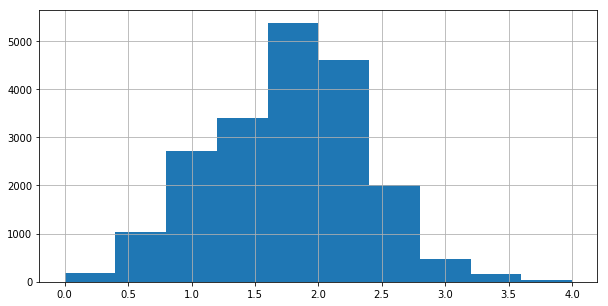

In [171]:
data['grulingv_rmse'].hist()

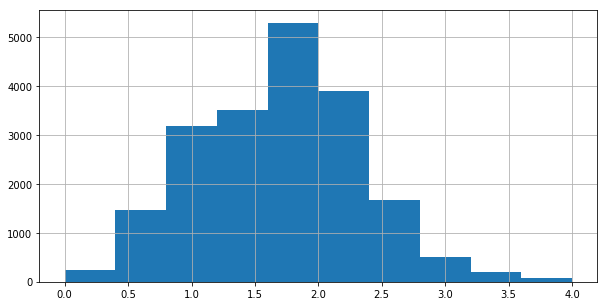

In [172]:
data['bleu_rmse'].hist()

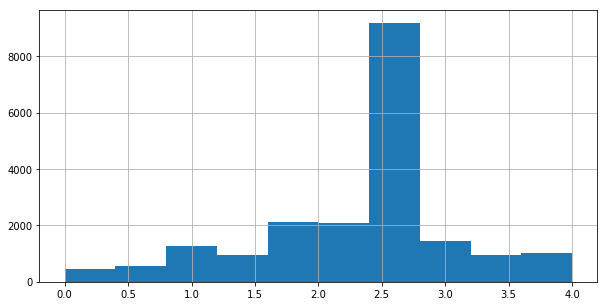

In [173]:
data['constant_rmse'].hist()